# EDA


#### Imports

In [2]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

filterwarnings("ignore")



#### variables

In [3]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))


#### Load dataset

In [3]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics-build/proccessed/chess-games.csv")
df

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                  Event  \
0                    0             0           0  FICS rated blitz game   
1                    1             1           0  FICS rated blitz game   
2                    2             2           0  FICS rated blitz game   
3                    3             3           0  FICS rated blitz game   
4                    4             4           0  FICS rated blitz game   
...                ...           ...         ...                    ...   
14717855       6004708          9996           0  FICS rated blitz game   
14717856       6004709          9997           0  FICS rated blitz game   
14717857       6004710          9998           0  FICS rated blitz game   
14717858       6004711          9999           0  FICS rated blitz game   
14717859       6004712         10000           0  FICS rated blitz game   

                        Site  FICSGamesDBGameNo          White          Black  \
0         FICS freechess.org          455505130        Strikko         boggus   
1         FICS freechess.org          455505129       Wychbold       Jarlaxle   
2         FICS freechess.org          455505128      Shaderman       tihibuda   
3         FICS freechess.org          455505126  aussenschnapp   SchachDieter   
4         FICS freechess.org          455505123          pfink          Tojul   
...                      ...                ...            ...            ...   
14717855  FICS freechess.org          434845469       Arembepe       bretteux   
14717856  FICS freechess.org          434845468     JonotheRed          HWPer   
14717857  FICS freechess.org          434845467      snackking        Jonfern   
14717858  FICS freechess.org          434845465           alza  Jesuslovesall   
14717859  FICS freechess.org          434845462   SorryYouLose         anzali   

          WhiteElo  BlackElo  ...        Date      Time   WhiteClock  \
0             1606      1607  ...  2019.11.30  08:05:00  0:03:00.000   
1             1311      1437  ...  2019.11.30  08:07:00  0:03:00.000   
2             1567      1516  ...  2019.11.30  08:06:00  0:03:00.000   
3             1680      1698  ...  2019.11.30  08:05:00  0:03:00.000   
4             1288      1174  ...  2019.11.30  07:56:00  0:10:00.000   
...            ...       ...  ...         ...       ...          ...   
14717855      1059      1155  ...  2018.08.09  12:16:00  0:03:00.000   
14717856      1501      1520  ...  2018.08.09  12:12:00  0:05:00.000   
14717857      1621      1676  ...  2018.08.09  12:13:00  0:03:00.000   
14717858      1333      1423  ...  2018.08.09  12:14:00  0:05:00.000   
14717859      1269      1383  ...  2018.08.09  12:11:00  0:05:00.000   

           BlackClock  ECO PlyCount Result  \
0         0:03:00.000  A27      156    0-1   
1         0:03:00.000  B21       60    0-1   
2         0:03:00.000  B06       75    1-0   
3         0:03:00.000  A43      109    1-0   
4         0:10:00.000  B94       71    0-1   
...               ...  ...      ...    ...   
14717855  0:03:00.000  B20       47    1-0   
14717856  0:05:00.000  C01      109    1-0   
14717857  0:03:00.000  C50       80    0-1   
14717858  0:05:00.000  B01       42    0-1   
14717859  0:05:00.000  C23       75    1-0   

                                                       Move  WhiteIsComp  \
0         | Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...          NaN   
1         | e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...          NaN   
2         | e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...          NaN   
3         | d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...          NaN   
4         | e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...          NaN   
...                                                     ...          ...   
14717855  | e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...          NaN   
14717856  | e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...          NaN   
14717857  | e4 e5 | Nf3 Nc6 | Bc4 

In [4]:
for c in [c for c in list(df.columns) if "Unnamed" in c]:
    df=df.drop(columns=c)

#### Remove unnecceary columns and save the cleaned result

In [5]:
df["Year"]=df["Date"].apply(lambda r:r.split(".")[0])
df=df.drop(columns="Site")
df=df.drop(columns="WhiteIsComp")
df=df.drop(columns="BlackIsComp")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean.csv")

#### Read the cleaned data for sanity

In [ ]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean.csv")
df

#### Win rate

In [6]:
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]
df["RelativeEloDiff"] = (
    ((df["WhiteElo"] / (df[["WhiteElo", "BlackElo"]].median(axis=1))) - 1.0) * 100.0
).round(2)
display(df.head())

Event  FICSGamesDBGameNo          White         Black  \
0  FICS rated blitz game          455505130        Strikko        boggus   
1  FICS rated blitz game          455505129       Wychbold      Jarlaxle   
2  FICS rated blitz game          455505128      Shaderman      tihibuda   
3  FICS rated blitz game          455505126  aussenschnapp  SchachDieter   
4  FICS rated blitz game          455505123          pfink         Tojul   

   WhiteElo  BlackElo  WhiteRD  BlackRD TimeControl        Date      Time  \
0      1606      1607     23.3     22.4       180+0  2019.11.30  08:05:00   
1      1311      1437     27.7     24.1       180+0  2019.11.30  08:07:00   
2      1567      1516     53.1     27.5       180+0  2019.11.30  08:06:00   
3      1680      1698     19.5     22.9       180+0  2019.11.30  08:05:00   
4      1288      1174     26.2     46.2       600+0  2019.11.30  07:56:00   

    WhiteClock   BlackClock  ECO  PlyCount Result  \
0  0:03:00.000  0:03:00.000  A27       156    0-1   
1  0:03:00.000  0:03:00.000  B21        60    0-1   
2  0:03:00.000  0:03:00.000  B06        75    1-0   
3  0:03:00.000  0:03:00.000  A43       109    1-0   
4  0:10:00.000  0:10:00.000  B94        71    0-1   

                                                Move  Year  EloDiff  \
0  | Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...  2019       -1   
1  | e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...  2019     -126   
2  | e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...  2019       51   
3  | d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...  2019      -18   
4  | e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...  2019      114   

   RelativeEloDiff  
0            -0.03  
1            -4.59  
2             1.65  
3            -0.53  
4             4.63

In [7]:
def win_rate_by_elo_diff(df,elo_diff):
    try:
        win_freq=Counter(df[df["EloDiff"] > elo_diff]["Result"])
        white_won=win_freq["1-0"]
        draw=win_freq["1/2-1/2"]
        black_won=win_freq["0-1"]
        total=white_won+draw+black_won
        white_wins_proportion = white_won / total
        white_loss_proportion = black_won / total
        draw_proportion = draw / total
        return pd.DataFrame({
            'EloDiff':[elo_diff],
            'TotalGames':[total],
            'WhiteWon':[white_won],
            'WhiteWinsProportion':[white_wins_proportion],
            'WhiteLossProportion':[white_loss_proportion],
            'BlackWon':[black_won],
            'Draw':[draw],
            'DrawProportion':[draw_proportion],
        })
    except Exception as err:
           return pd.DataFrame({
            'EloDiff':[ ],
            'TotalGames':[ ],
            'WhiteWon':[ ],
            'WhiteWinsProportion':[ ],
            'WhiteLossProportion':[ ],
            'BlackWon':[ ],
            'Draw':[ ],
            'DrawProportion':[ ],
        })

Text(0.5, 1.0, 'Elo range group vs Count')

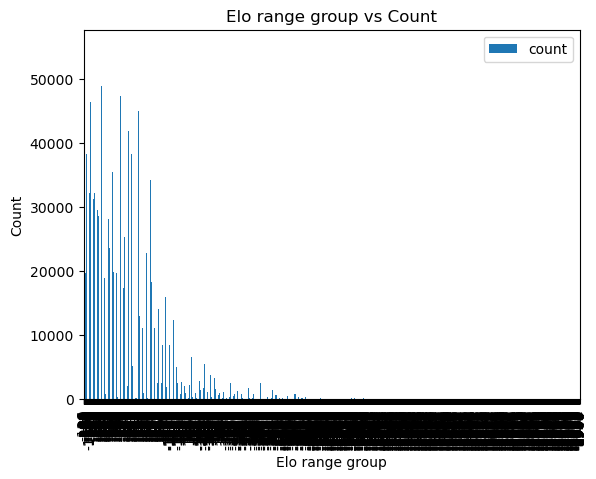

In [8]:
diffs=Counter(list(df["EloDiff"]))

freq_d={
    "amount":[],
    "count":[],
}

for k,v in diffs.items():
    freq_d["amount"].append(k)
    freq_d["count"].append(v)
    
df_freq=pd.DataFrame.from_dict(freq_d)
ax=df_freq.plot(kind='bar',x='amount',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")



Text(0.5, 1.0, 'Elo range group vs Count')

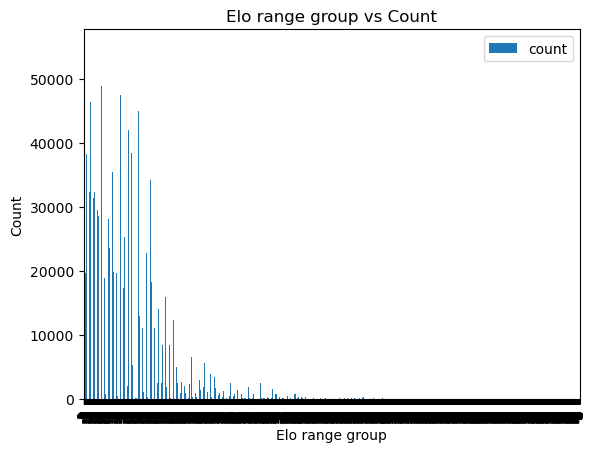

In [9]:
diffs=Counter(list(df["EloDiff"]))

freq_d={
    "amount":[],
    "count":[],
}

for k,v in diffs.items():
    freq_d["amount"].append(k//400)
    freq_d["count"].append(v)
    
df_freq=pd.DataFrame.from_dict(freq_d)
ax=df_freq.plot(kind='bar',x='amount',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")



(-2351.694, -2310.328]    1
(-2310.328, -2273.656]    0
(-2273.656, -2236.984]    3
(-2236.984, -2200.312]    4
(-2200.312, -2163.641]    3
                         ..
(2163.641, 2200.312]      1
(2200.312, 2236.984]      3
(2236.984, 2273.656]      3
(2273.656, 2310.328]      1
(2310.328, 2347.0]        1
Name: count, Length: 128, dtype: int64


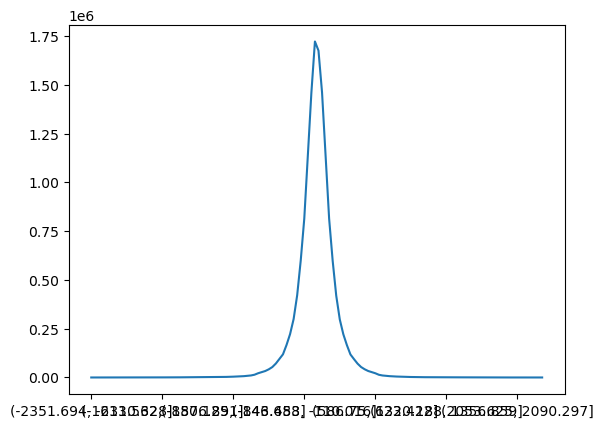

In [10]:
# counts, bin_edges = np.histogram(df_freq, bins=10)
# Creating bins
categories = pd.cut(list(df["EloDiff"]), bins=128)

# Getting the frequency distribution
frequency_distribution = categories.value_counts()

frequency_distribution.plot()
print(frequency_distribution)

In [11]:
all=sorted(list(df["EloDiff"]))

In [12]:
print(min(all),max(all))

-2347 2347


/tmp/ipykernel_5344/1829129545.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


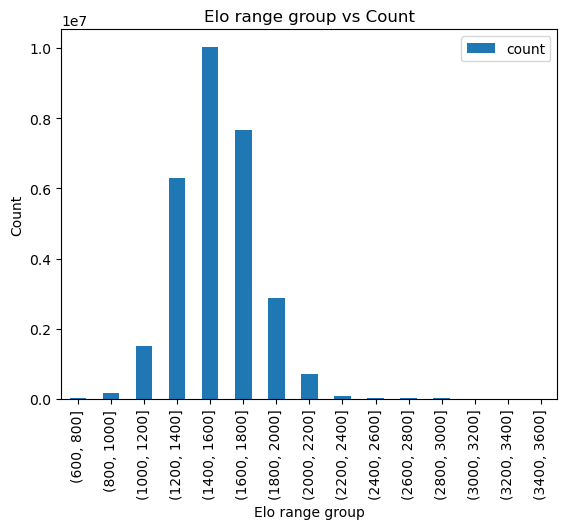

In [13]:
def get_elo_freq(df):
    freq_elo_black=Counter(list(df["BlackElo"]))
    freq_elo_white=Counter(list(df["WhiteElo"]))
    both={}
    for k,v in freq_elo_black.items():
        both[k]=v

    for k,v in freq_elo_white.items():
        both[k]=both.get(k,0)+v
    keys=list(both.keys())
    vals=list(both.values())
    frame=pd.DataFrame({
        'Elo':keys,
        'Count':vals,
    }).sort_values('Count',ascending=True)
    return frame




elo_freq=get_elo_freq(df)
elo_freq=elo_freq[["Elo","Count"]]
rating_bins = np.arange(600,3601, 200)
cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
elo_freq["group"]=cuts
groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
ax=elo_freq.plot(kind='bar',x='group',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years.png")

-------------------------------------------------- Player ratio --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0     94510.0   90734.0             0.960047             0.032959   
0    800.0     38619.0   37910.0             0.981641             0.014423   
0   1000.0     19612.0   19403.0             0.989343             0.007801   
0   1200.0     10978.0   10916.0             0.994352             0.003826   
0   1400.0      5847.0    5831.0             0.997264             0.002223   
0   1600.0      2313.0    2308.0             0.997838             0.002162   
0   1800.0       693.0     693.0             1.000000             0.000000   
0   2000.0       129.0     129.0             1.000000             0.000000   
0   2200.0         8.0       8.0             1.000000             0.000000   

   BlackWon   Draw  DrawProportion  
0    3115.0  661.0        0.006994  
0     557.0  152.0        0.003936  
0     153.0   56.0        0.002855  
0      42.0   20.0        0.001822  
0      13.0    3.0        0.000513  
0       5.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000

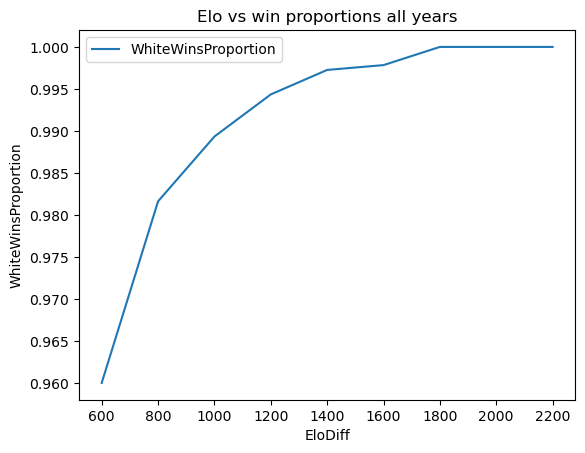

In [14]:
frames=[]
for diff in np.arange(600,3601, 200):
    frames.append(win_rate_by_elo_diff(df,diff))

frames_df=pd.concat(frames)
print("-"*50,"Player ratio","-"*50)
display(frames_df)
ax= frames_df.plot.line(x='EloDiff', y='WhiteWinsProportion')

ax.set_xlabel("EloDiff")
ax.set_ylabel("WhiteWinsProportion")
ax.set_title("Elo vs win proportions all years")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-vs-win-proportions-all-years.png")

-------------------------------------------------- Player ratio for year 2003 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2004 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2005 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2006 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2007 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2008 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2009 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2010 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2011 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2012 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2013 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2014 --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0         1.0       0.0                  0.0                  1.0   

   BlackWon  Draw  DrawProportion  
0       1.0   0.0             0.0

-------------------------------------------------- Player ratio for year 2015 --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0         1.0       1.0                  1.0                  0.0   

   BlackWon  Draw  DrawProportion  
0       0.0   0.0             0.0

-------------------------------------------------- Player ratio for year 2016 --------------------------------------------------


Empty DataFrame
Columns: [EloDiff, TotalGames, WhiteWon, WhiteWinsProportion, WhiteLossProportion, BlackWon, Draw, DrawProportion]
Index: []

-------------------------------------------------- Player ratio for year 2017 --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0         5.0       4.0                  0.8                  0.2   

   BlackWon  Draw  DrawProportion  
0       1.0   0.0             0.0

-------------------------------------------------- Player ratio for year 2018 --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0     38260.0   36638.0             0.957606             0.035180   
0    800.0     16254.0   15942.0             0.980805             0.015258   
0   1000.0      8665.0    8584.0             0.990652             0.006463   
0   1200.0      4956.0    4927.0             0.994149             0.004237   
0   1400.0      2427.0    2417.0             0.995880             0.002884   
0   1600.0       967.0     964.0             0.996898             0.003102   
0   1800.0       267.0     267.0             1.000000             0.000000   
0   2000.0        40.0      40.0             1.000000             0.000000   

   BlackWon   Draw  DrawProportion  
0    1346.0  276.0        0.007214  
0     248.0   64.0        0.003937  
0      56.0   25.0        0.002885  
0      21.0    8.0        0.001614  
0       7.0    3.0        0.001236  
0       3.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000

-------------------------------------------------- Player ratio for year 2019 --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0     31504.0   30334.0             0.962862             0.030536   
0    800.0     13041.0   12813.0             0.982517             0.014723   
0   1000.0      6248.0    6169.0             0.987356             0.010723   
0   1200.0      3253.0    3237.0             0.995081             0.002767   
0   1400.0      1690.0    1688.0             0.998817             0.001183   
0   1600.0       583.0     583.0             1.000000             0.000000   
0   1800.0       164.0     164.0             1.000000             0.000000   
0   2000.0        30.0      30.0             1.000000             0.000000   
0   2200.0         4.0       4.0             1.000000             0.000000   

   BlackWon   Draw  DrawProportion  
0     962.0  208.0        0.006602  
0     192.0   36.0        0.002761  
0      67.0   12.0        0.001921  
0       9.0    7.0        0.002152  
0       2.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000

-------------------------------------------------- Player ratio for year 2020 --------------------------------------------------


EloDiff  TotalGames  WhiteWon  WhiteWinsProportion  WhiteLossProportion  \
0    600.0     24739.0   23757.0             0.960306             0.032540   
0    800.0      9324.0    9155.0             0.981875             0.012548   
0   1000.0      4699.0    4650.0             0.989572             0.006384   
0   1200.0      2769.0    2752.0             0.993861             0.004334   
0   1400.0      1730.0    1726.0             0.997688             0.002312   
0   1600.0       763.0     761.0             0.997379             0.002621   
0   1800.0       262.0     262.0             1.000000             0.000000   
0   2000.0        59.0      59.0             1.000000             0.000000   
0   2200.0         4.0       4.0             1.000000             0.000000   

   BlackWon   Draw  DrawProportion  
0     805.0  177.0        0.007155  
0     117.0   52.0        0.005577  
0      30.0   19.0        0.004043  
0      12.0    5.0        0.001806  
0       4.0    0.0        0.000000  
0       2.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000  
0       0.0    0.0        0.000000

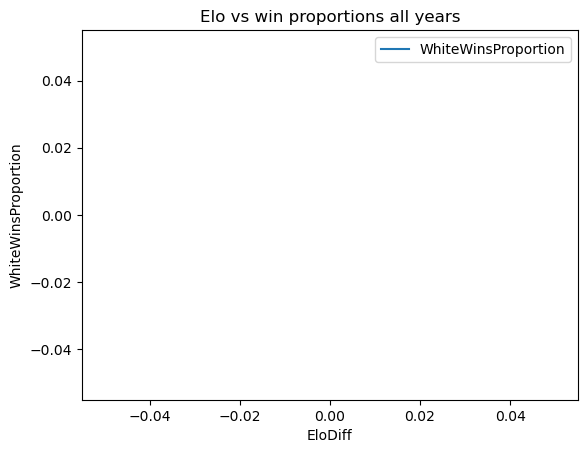

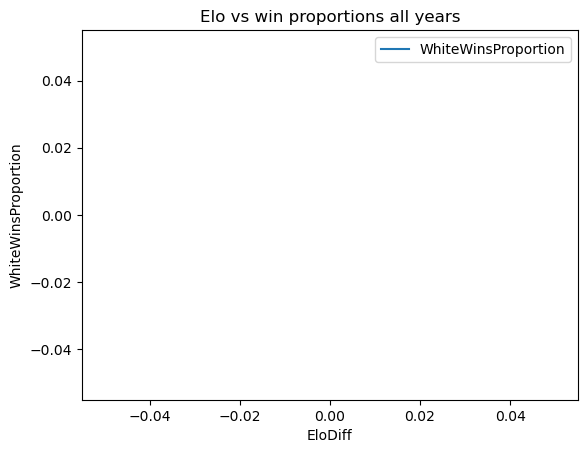

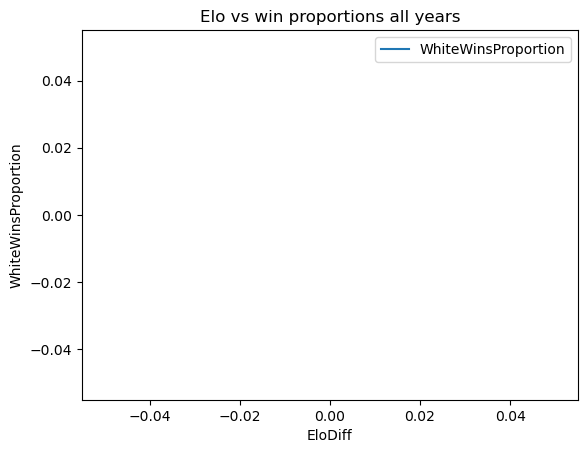

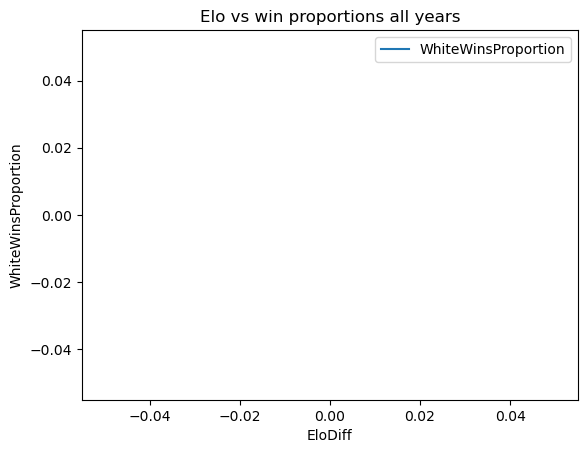

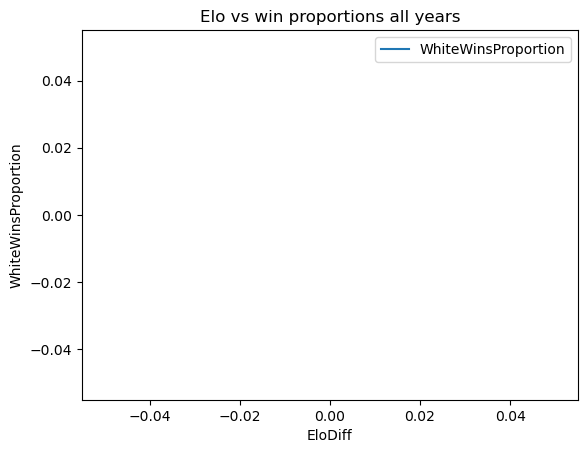

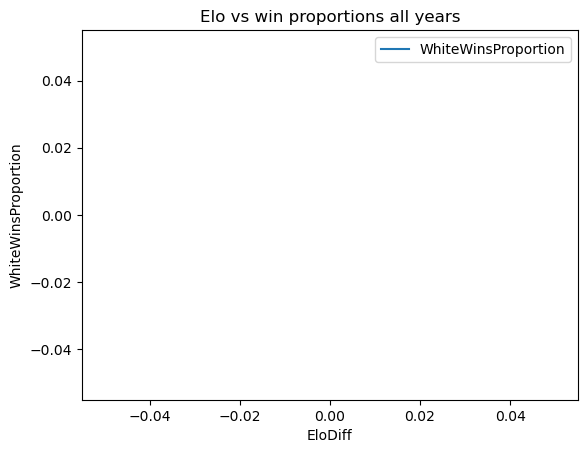

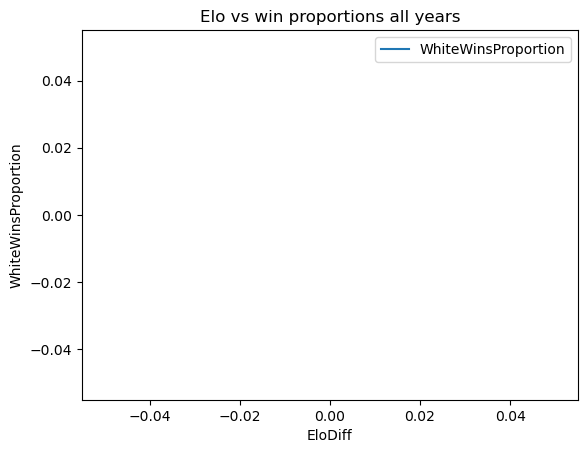

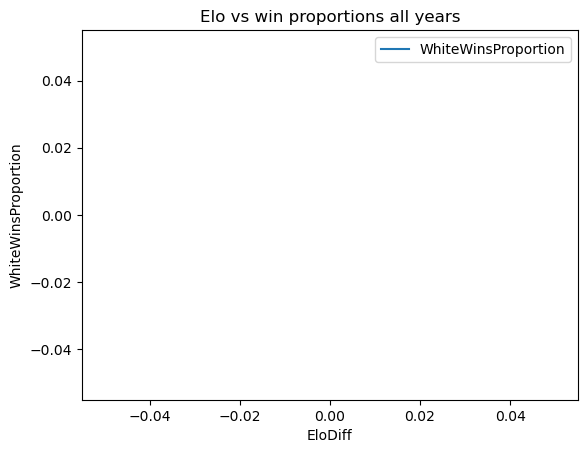

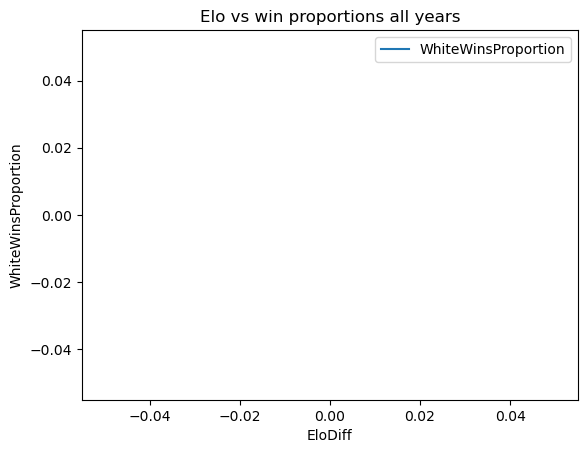

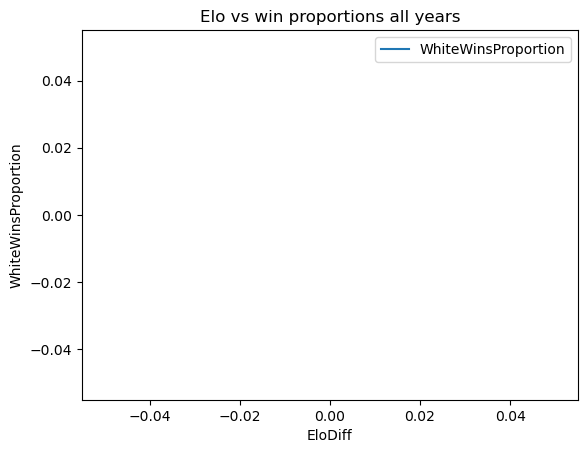

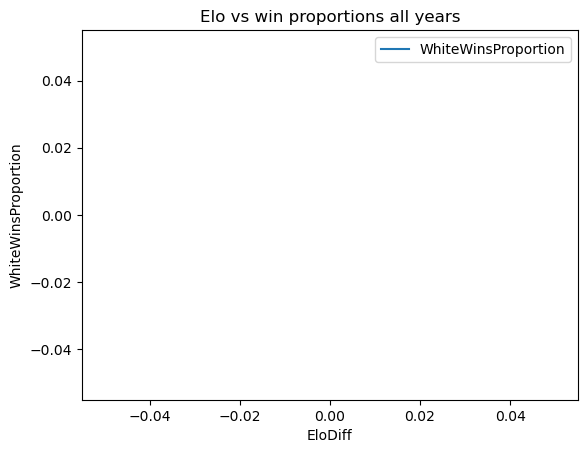

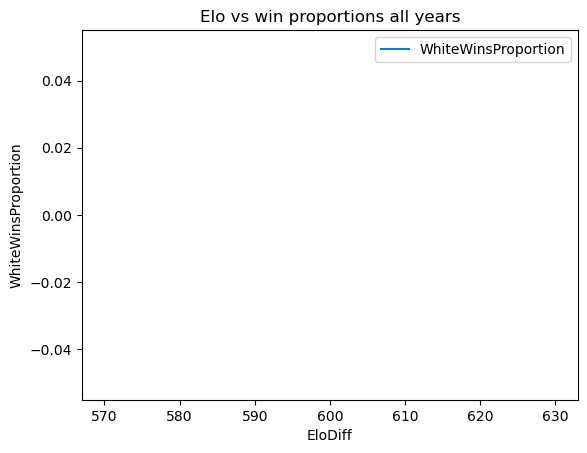

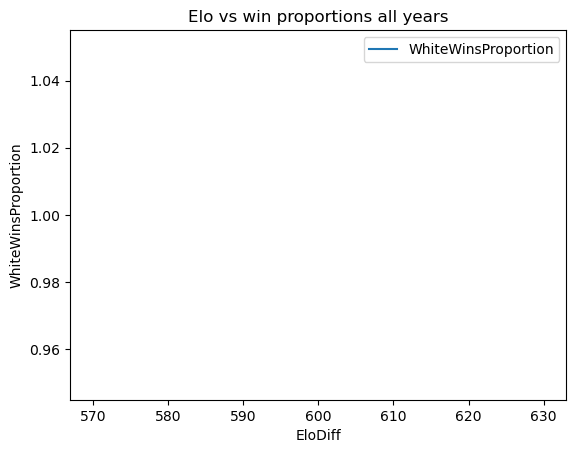

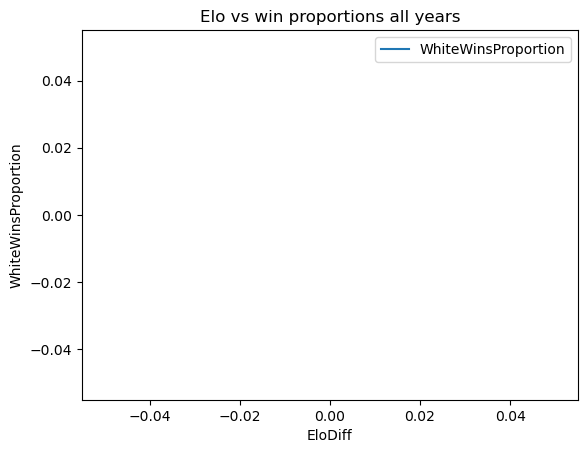

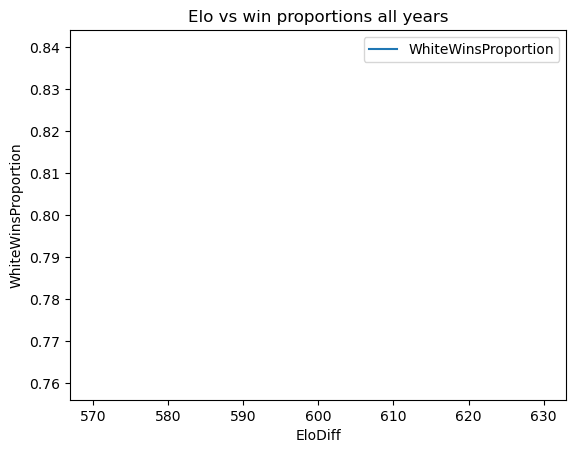

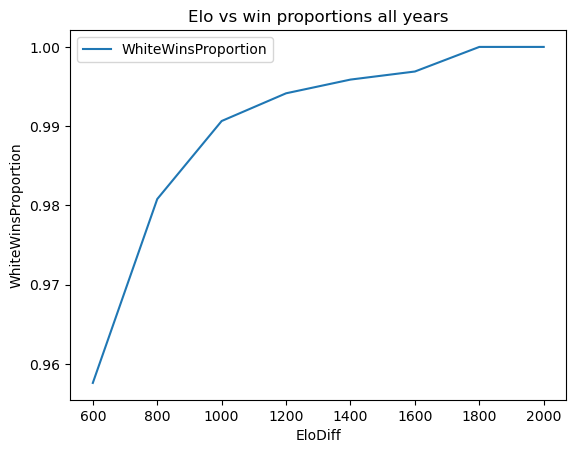

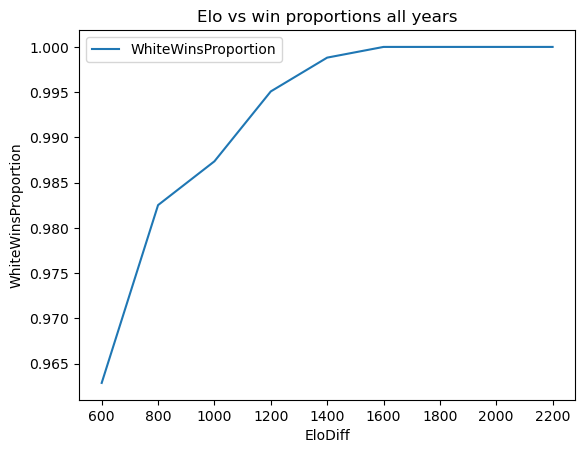

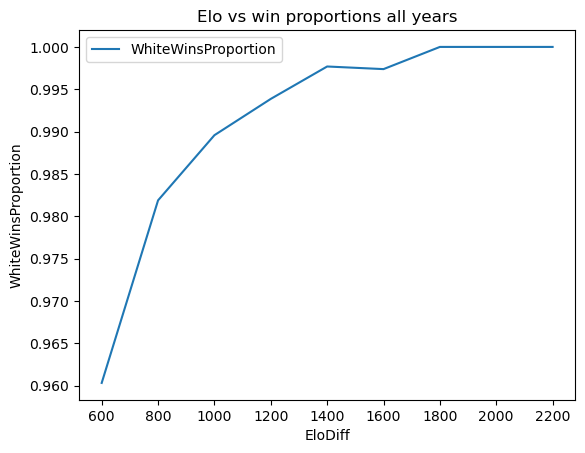

In [15]:

for year in sorted(list(set(df["Year"]))):
    frames=[]
    for diff in np.arange(600,3601, 200):
        frames.append(win_rate_by_elo_diff(df[df["Year"]==year],diff))

    frames_df=pd.concat(frames)

    frames_df=pd.concat(frames)
    print("-"*50,"Player ratio for year",year,"-"*50)
    display(frames_df)
    ax= frames_df.plot.line(x='EloDiff', y='WhiteWinsProportion')

    ax.set_xlabel("EloDiff")
    ax.set_ylabel("WhiteWinsProportion")
    ax.set_title("Elo vs win proportions all years")

    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-vs-win-proportions-{year}.png")

In [16]:
win_freq2=Counter(df[df["EloDiff"] > 20]["Result"])
white_won2=win_freq2["1-0"]
draw2=win_freq2["1/2-1/2"]
black_won2=win_freq2["0-1"]
total2=white_won2+draw2+black_won2
white_wins_proportion2 = white_won2 / total2
white_loss_proportion2 = black_won2 / total2
draw_proportion2 = draw2 / total2
print(
    f"Out of {total2} games:\n  White won {white_won2} games "
    f"({white_wins_proportion2:.2%}).\n  White lost {black_won2} games "
    f"({white_loss_proportion2:.2%}).\n"
    f"  White draw {draw2} games ({draw_proportion2:.2%}).  "
)

Out of 6377852 games:
  White won 4130191 games (64.76%).
  White lost 2011232 games (31.53%).
  White draw 236429 games (3.71%).  


#### Elo distributions

In [17]:
def get_elo_freq(df):
    freq_elo_black=Counter(list(df["BlackElo"]))
    freq_elo_white=Counter(list(df["WhiteElo"]))
    both={}
    for k,v in freq_elo_black.items():
        both[k]=v

    for k,v in freq_elo_white.items():
        both[k]=both.get(k,0)+v
    keys=list(both.keys())
    vals=list(both.values())
    frame=pd.DataFrame({
        'Elo':keys,
        'Count':vals,
    }).sort_values('Count',ascending=True)
    print(min(keys))
    print(max(keys))
    return frame

228
3293


/tmp/ipykernel_5344/2039240596.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


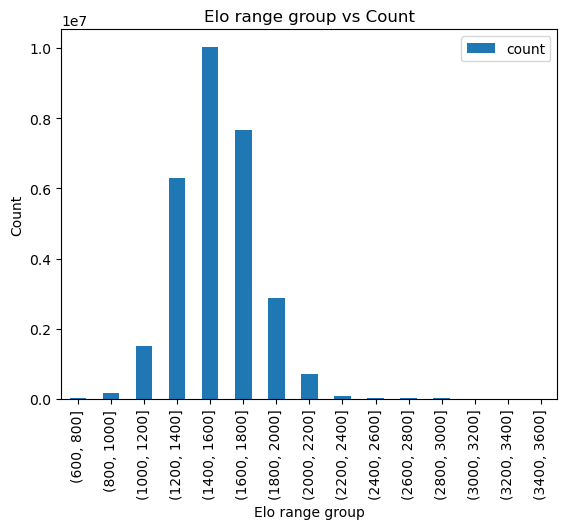

In [18]:
elo_freq=get_elo_freq(df)
elo_freq=elo_freq[["Elo","Count"]]
rating_bins = np.arange(600,3601, 200)
cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
elo_freq["group"]=cuts
groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
ax=elo_freq.plot(kind='bar',x='group',y='count')
ax.set_xlabel("Elo range group")
ax.set_ylabel("Count")
ax.set_title("Elo range group vs Count")

ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years.png")

In [19]:
(3500-300)/128

25.0

In [20]:
groups={str(k):[] for k in range(300,3500,25)}
groups

{'300': [],
 '325': [],
 '350': [],
 '375': [],
 '400': [],
 '425': [],
 '450': [],
 '475': [],
 '500': [],
 '525': [],
 '550': [],
 '575': [],
 '600': [],
 '625': [],
 '650': [],
 '675': [],
 '700': [],
 '725': [],
 '750': [],
 '775': [],
 '800': [],
 '825': [],
 '850': [],
 '875': [],
 '900': [],
 '925': [],
 '950': [],
 '975': [],
 '1000': [],
 '1025': [],
 '1050': [],
 '1075': [],
 '1100': [],
 '1125': [],
 '1150': [],
 '1175': [],
 '1200': [],
 '1225': [],
 '1250': [],
 '1275': [],
 '1300': [],
 '1325': [],
 '1350': [],
 '1375': [],
 '1400': [],
 '1425': [],
 '1450': [],
 '1475': [],
 '1500': [],
 '1525': [],
 '1550': [],
 '1575': [],
 '1600': [],
 '1625': [],
 '1650': [],
 '1675': [],
 '1700': [],
 '1725': [],
 '1750': [],
 '1775': [],
 '1800': [],
 '1825': [],
 '1850': [],
 '1875': [],
 '1900': [],
 '1925': [],
 '1950': [],
 '1975': [],
 '2000': [],
 '2025': [],
 '2050': [],
 '2075': [],
 '2100': [],
 '2125': [],
 '2150': [],
 '2175': [],
 '2200': [],
 '2225': [],
 '2250': [],
 

1655
1872


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


1614
1892


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


981
1238


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


729
1687


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


890
1857


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


807
1772


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


675
1679


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


602
1774


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


746
1978


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


828
1972


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


791
1961


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


832
2213


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


940
2139


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


583
2077


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


726
2423


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


228
3261


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


447
3293


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


312
3046


/tmp/ipykernel_5344/845625475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


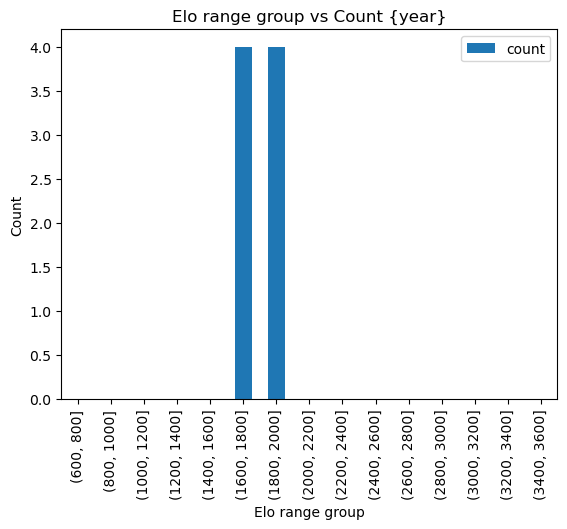

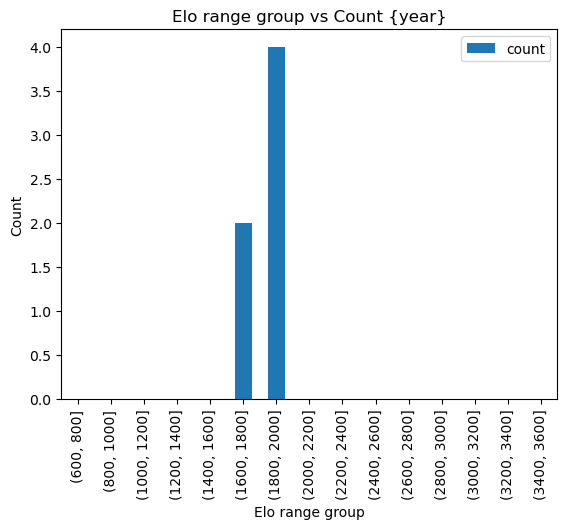

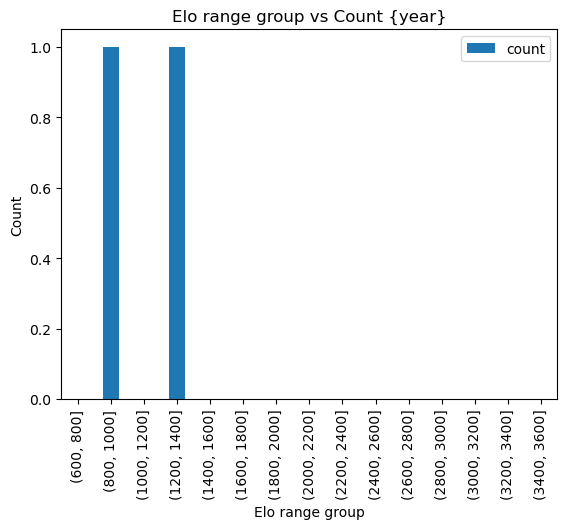

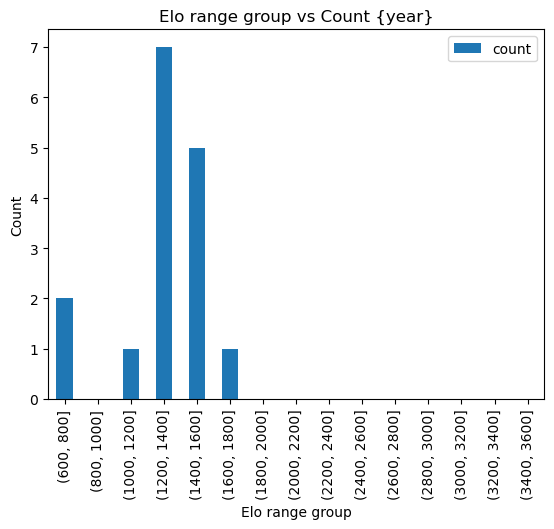

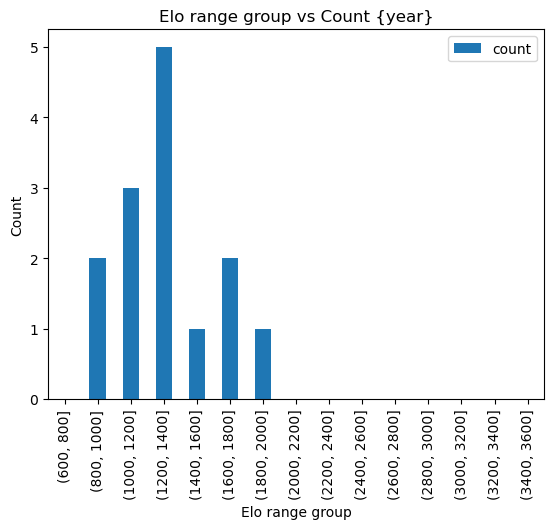

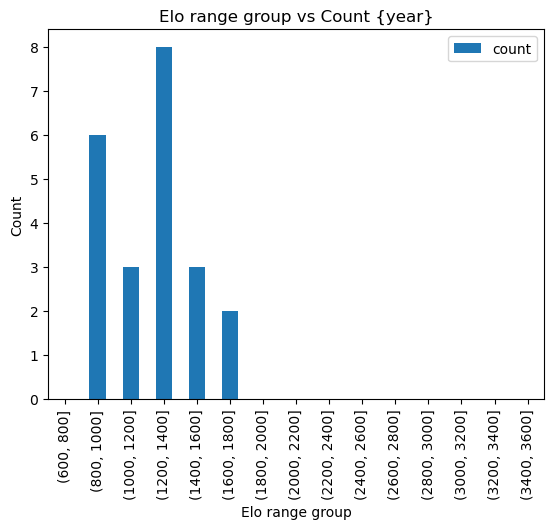

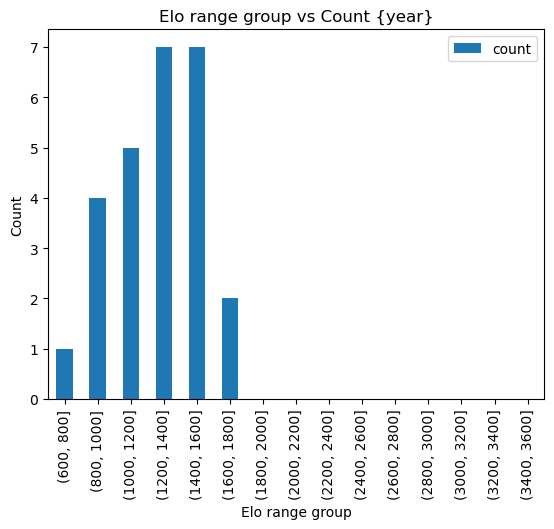

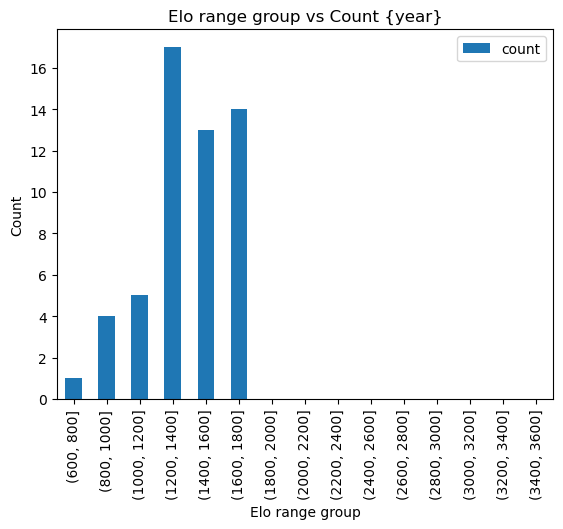

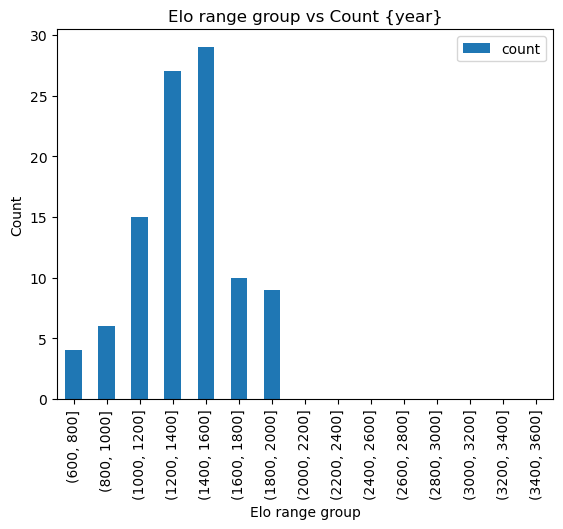

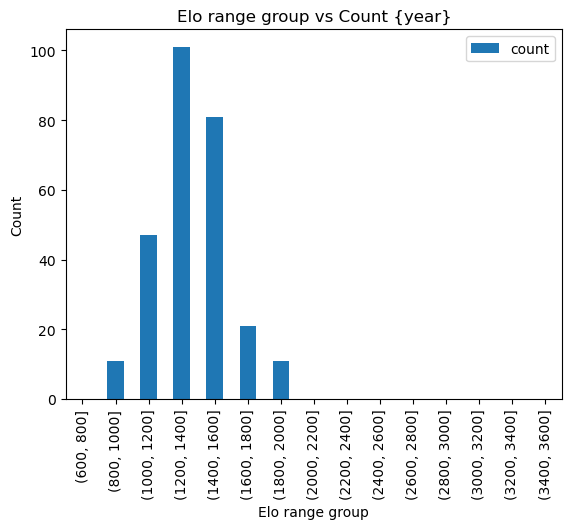

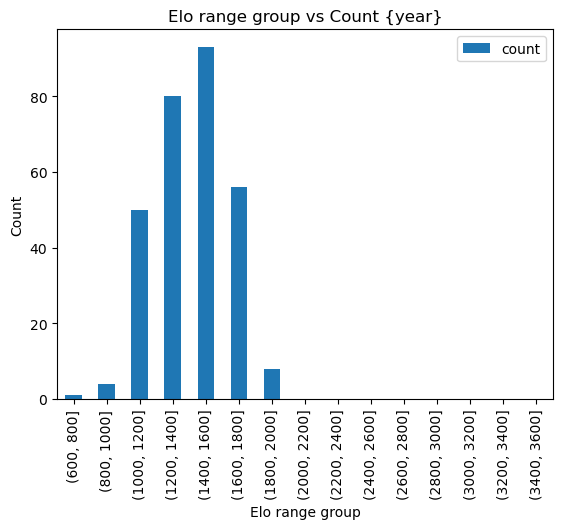

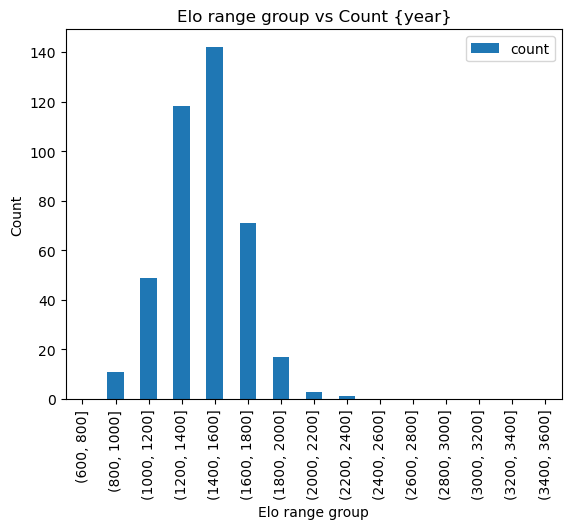

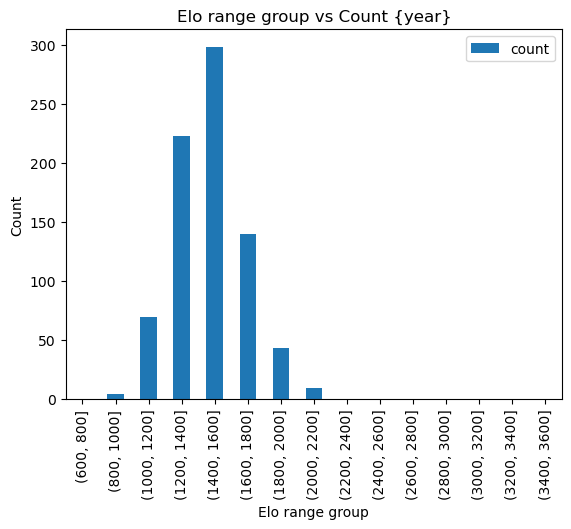

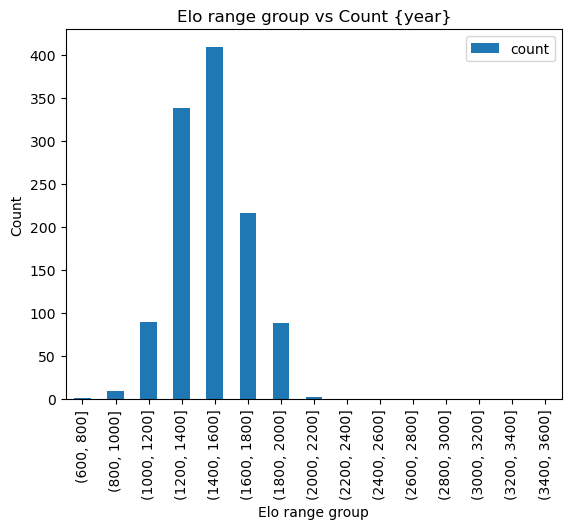

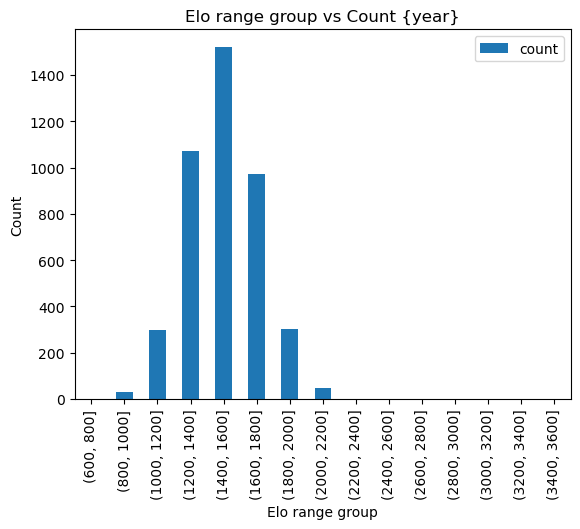

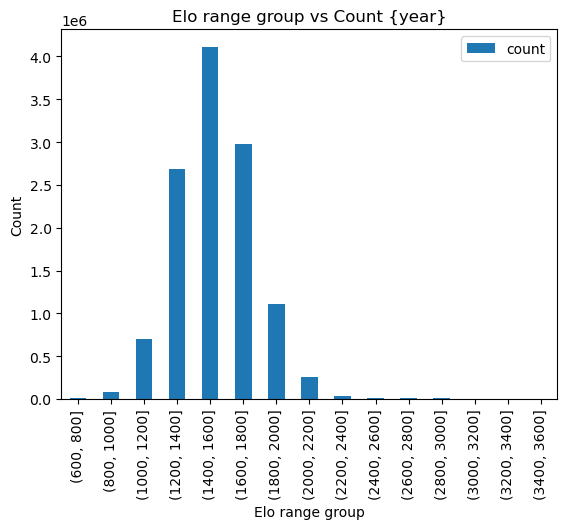

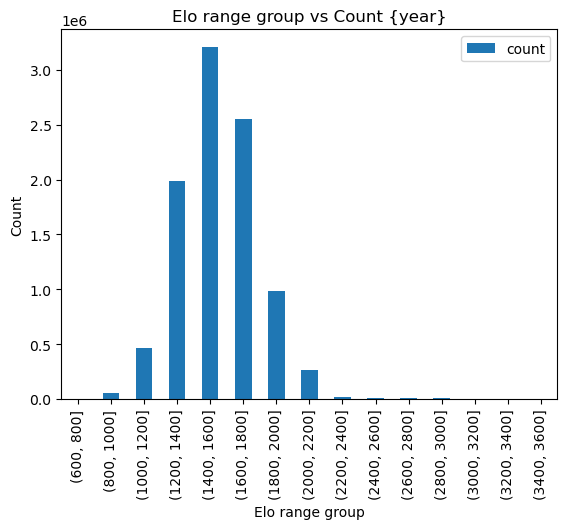

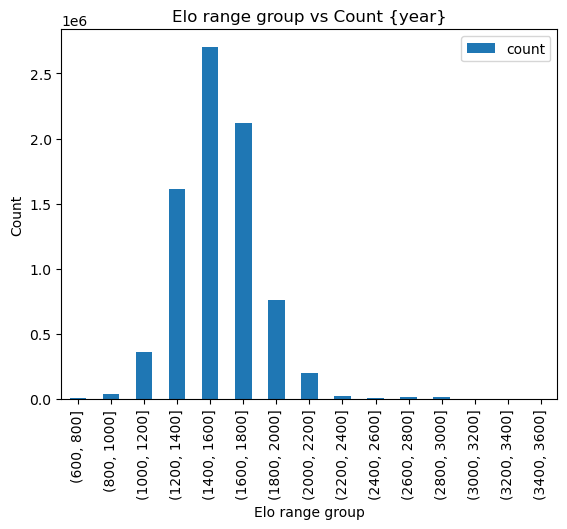

In [21]:
for year in sorted(list(set(df["Year"]))):
    elo_freq=get_elo_freq(df[df["Year"]==year])
    elo_freq=elo_freq[["Elo","Count"]]
    rating_bins = np.arange(600,3601, 200)
    cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
    elo_freq["group"]=cuts
    groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
    elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
    ax=elo_freq.plot(kind='bar',x='group',y='count')
    ax.set_title(f"Elo range group vs count for {year}")
    ax.set_xlabel("Elo range group")
    ax.set_ylabel("Count")
    ax.set_title("Elo range group vs Count {year}")
    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-{year}.png")

228
3293


/tmp/ipykernel_5344/2052553180.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


395
3285


/tmp/ipykernel_5344/2052553180.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]


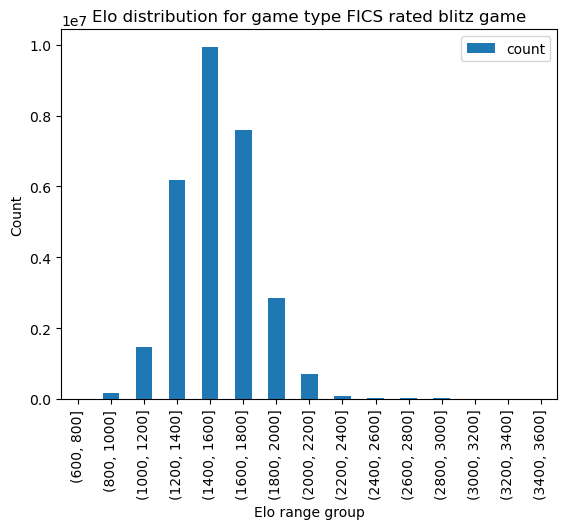

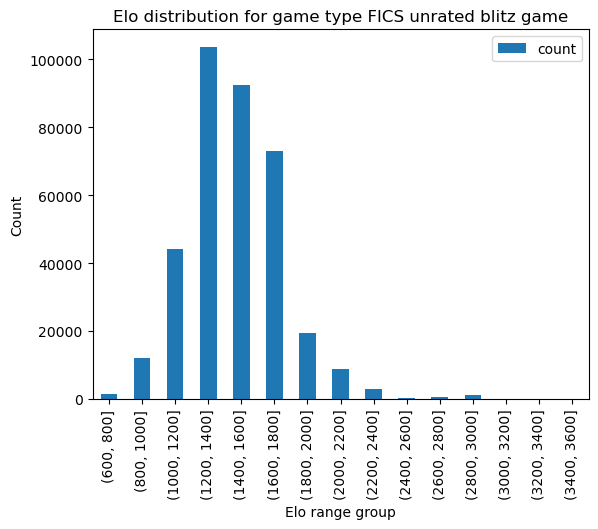

In [22]:
events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]

    elo_freq=get_elo_freq(df_e)
    elo_freq=elo_freq[["Elo","Count"]]
    rating_bins = np.arange(600,3601, 200)
    cuts=pd.cut(elo_freq["Elo"], bins=rating_bins)
    elo_freq["group"]=cuts
    groups=elo_freq.groupby('group').sum(["count"]).drop(columns="Elo")["Count"]
    elo_freq=pd.DataFrame.from_dict({'group':list(groups.index.astype(str)),'count':list(groups.values)})
    ax=elo_freq.plot(kind='bar',x='group',y='count')
    ax.set_xlabel("Elo range group")
    ax.set_ylabel("Count")
    ax.set_title(f"Elo distribution for game type {e}")
    ax.figure.savefig(f"{PROJECT_PATH}/reports/figures/fics/Elo-range-group-vs-Count-all-years-{e}.png")

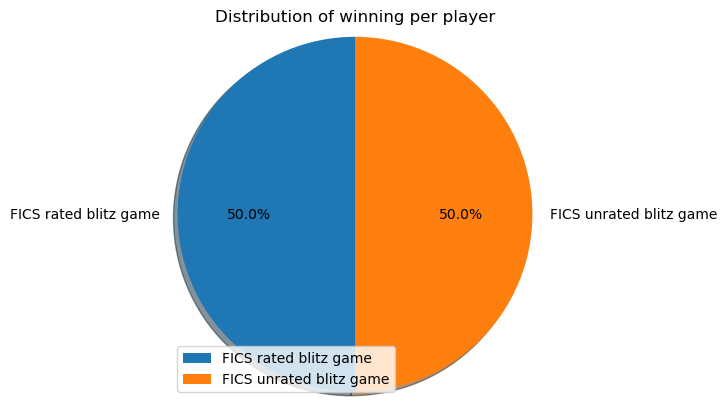

In [23]:
import matplotlib.pyplot as plt


by_event={e:len(df["Event"]==e) for e in list(set(list(df["Event"])))}
# defining labels
activities = list(by_event.keys())

# portion covered by each label
slices = list(by_event.values())

# color for each label
colors = ['r', 'y', 'g', 'b']

# plotting the pie chart
ax=plt.pie(slices, labels = activities,
        startangle=90, shadow = True,
        radius = 1.2, autopct = '%1.1f%%')

# plotting legend
plt.legend()
plt.title("Distribution of winning per player")


plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Distribution-of-winning-per-player-all-years-{e}.png")

# showing the plot
plt.show()


#### Number of games distributions

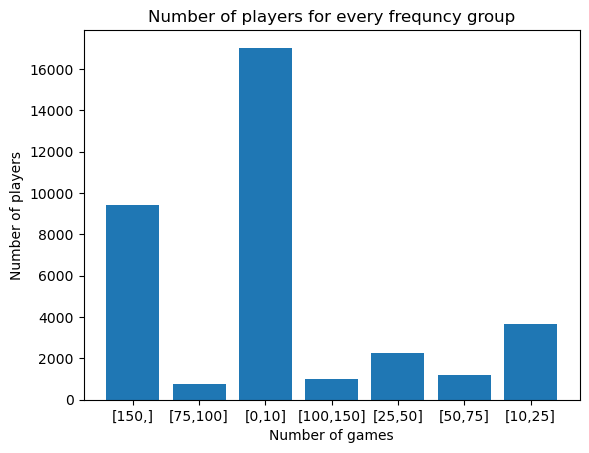

In [24]:
from collections import Counter
white_freq=Counter(list(df["White"]))
black_freq=Counter(list(df["Black"]))
all_freq=white_freq

for k,v in black_freq.items():
    all_freq[k]=all_freq.get(k,0)+v

count_freq={}
for k,v in all_freq.items():
    if v <=10:
        count_freq["[0,10]"]=count_freq.get("[0,10]",0)+1
    elif v <=25:
        count_freq["[10,25]"]=count_freq.get("[10,25]",0)+1
    elif v <=50:
        count_freq["[25,50]"]=count_freq.get("[25,50]",0)+1
    elif v <=75:
        count_freq["[50,75]"]=count_freq.get("[50,75]",0)+1
    elif v <=100:
        count_freq["[75,100]"]=count_freq.get("[75,100]",0)+1
    elif v <=150:
        count_freq["[100,150]"]=count_freq.get("[100,150]",0)+1
    else:
        count_freq["[150,]"]=count_freq.get("[150,]",0)+1

x = list(count_freq.keys())
y = list(count_freq.values())
plt.xlabel('Number of games')
plt.ylabel('Number of players')
plt.title('Number of players for every frequncy group')
plt.bar( x, y)
plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group.png")


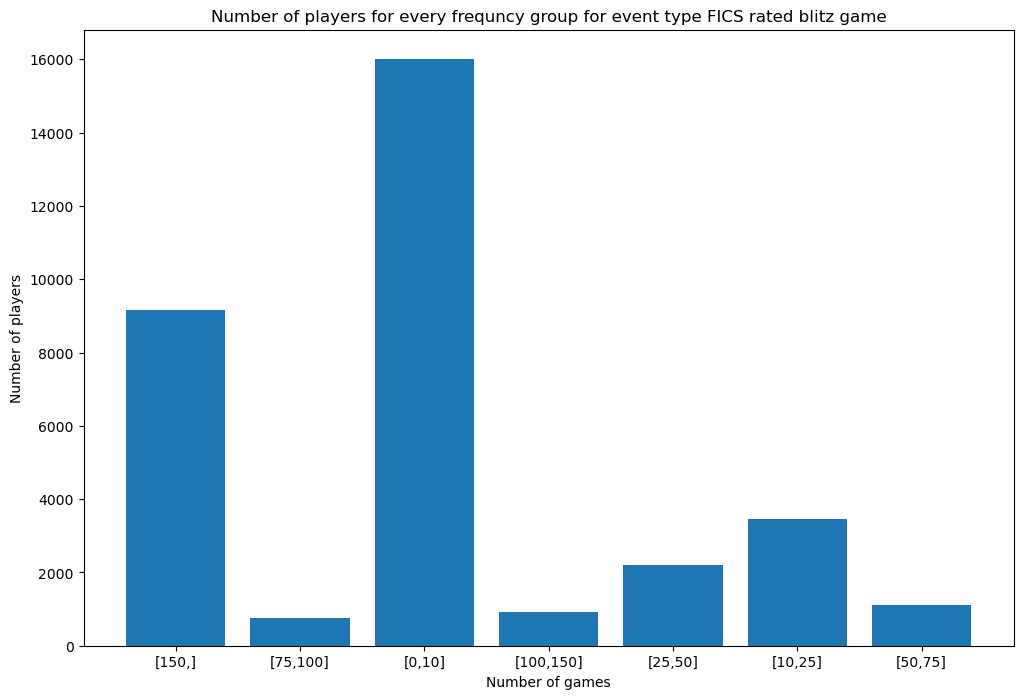

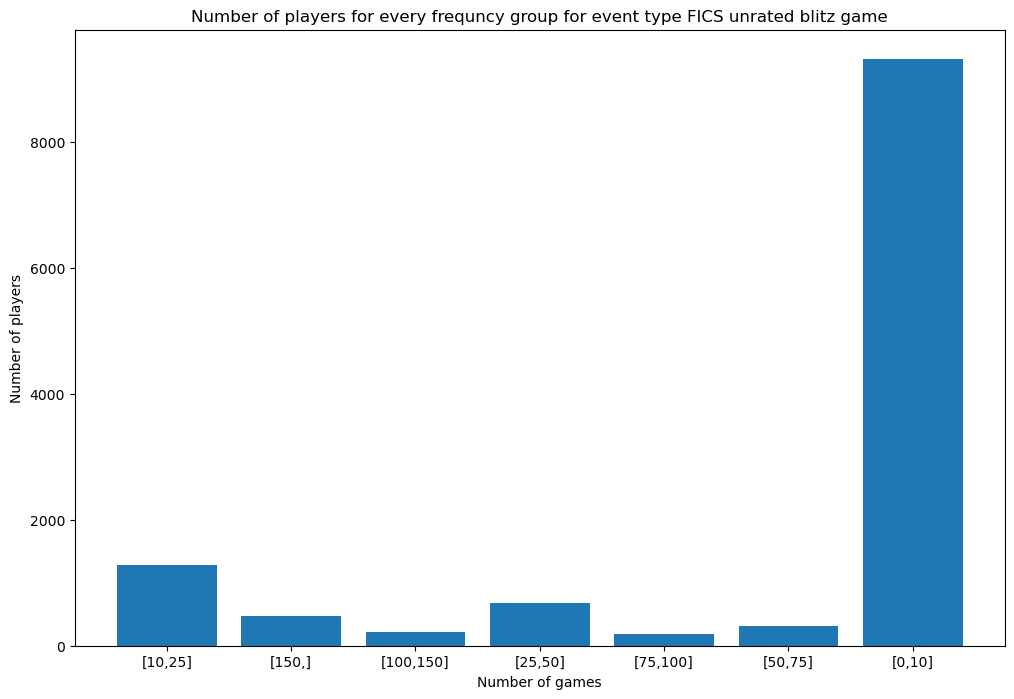

In [25]:
from collections import Counter

events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]
    white_freq=Counter(list(df_e["White"]))
    black_freq=Counter(list(df_e["Black"]))
    all_freq=white_freq

    for k,v in black_freq.items():
        all_freq[k]=all_freq.get(k,0)+v

    count_freq={}
    for k,v in all_freq.items():
        if v <=10:
            count_freq["[0,10]"]=count_freq.get("[0,10]",0)+1
        elif v <=25:
            count_freq["[10,25]"]=count_freq.get("[10,25]",0)+1
        elif v <=50:
            count_freq["[25,50]"]=count_freq.get("[25,50]",0)+1
        elif v <=75:
            count_freq["[50,75]"]=count_freq.get("[50,75]",0)+1
        elif v <=100:
            count_freq["[75,100]"]=count_freq.get("[75,100]",0)+1
        elif v <=150:
            count_freq["[100,150]"]=count_freq.get("[100,150]",0)+1
        else:
            count_freq["[150,]"]=count_freq.get("[150,]",0)+1
    plt.figure(figsize=(12, 8))
    x = list(count_freq.keys())
    y = list(count_freq.values())
    plt.xlabel('Number of games')
    plt.ylabel('Number of players')
    plt.title(f'Number of players for every frequncy group for event type {e}')
    plt.bar( x, y)
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group-for-event-type-{e}.png")


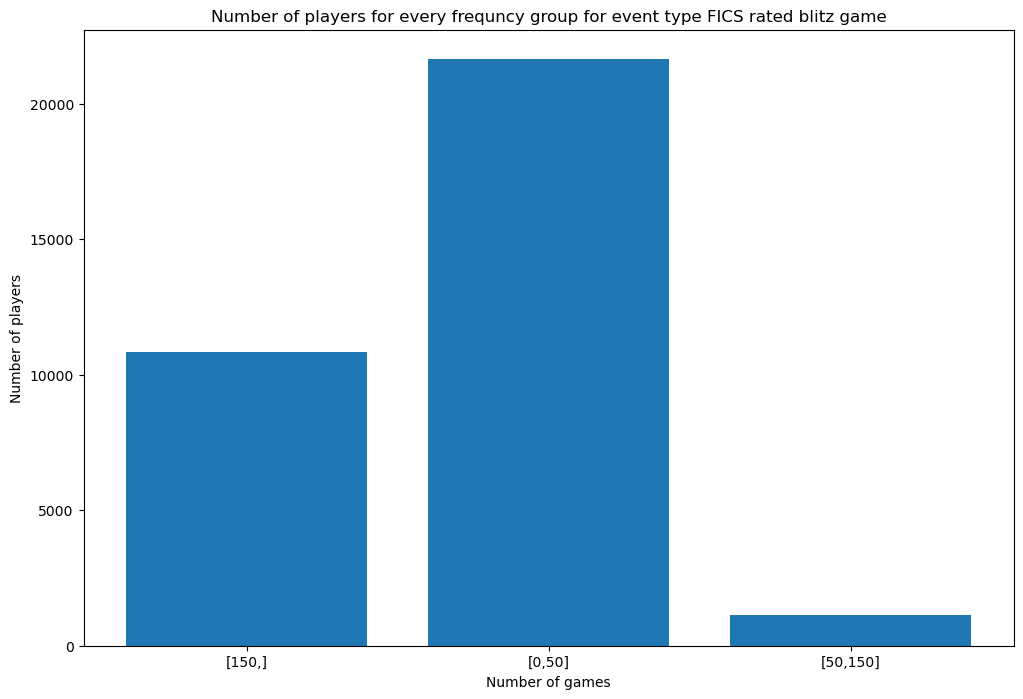

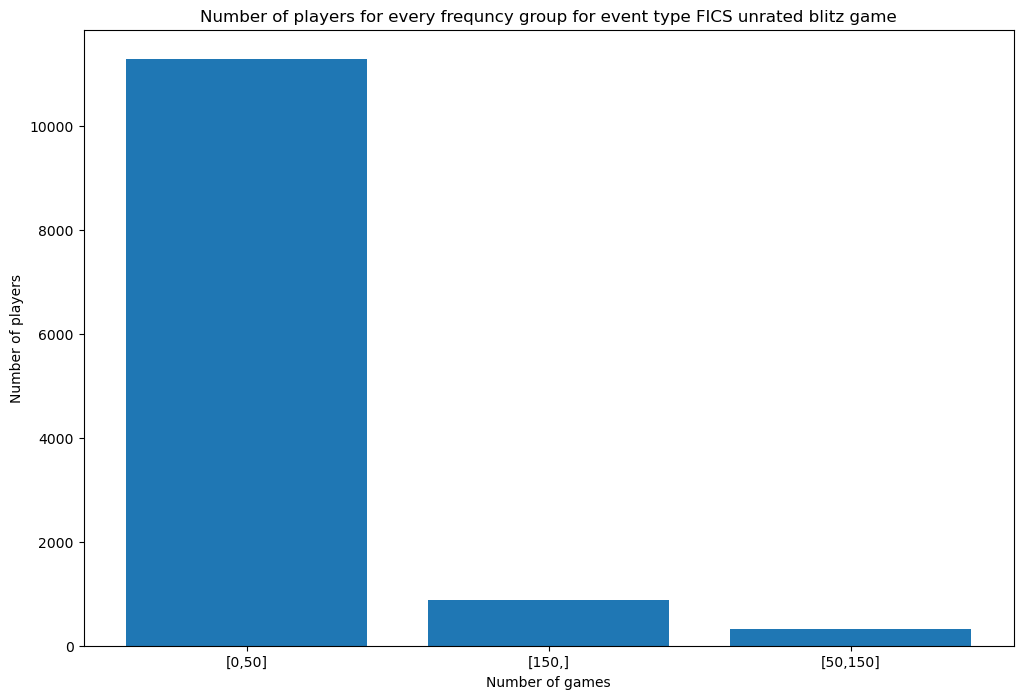

In [26]:
from collections import Counter

events=list(set(list(df["Event"])))


for e in events:
    df_e=df[df["Event"]==e]
    white_freq=Counter(list(df_e["White"]))
    black_freq=Counter(list(df_e["Black"]))
    all_freq=white_freq

    for k,v in black_freq.items():
        all_freq[k]=all_freq.get(k,0)+v

    count_freq={}
    for k,v in all_freq.items():
        if v <=50:
            count_freq["[0,50]"]=count_freq.get("[0,50]",0)+1
        elif v <=75:
            count_freq["[50,150]"]=count_freq.get("[50,150]",0)+1
        else:
            count_freq["[150,]"]=count_freq.get("[150,]",0)+1
    plt.figure(figsize=(12, 8))
    x = list(count_freq.keys())
    y = list(count_freq.values())
    plt.xlabel('Number of games')
    plt.ylabel('Number of players')
    plt.title(f'Number of players for every frequncy group for event type {e}')
    plt.bar( x, y)
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/Number-of-players-for-every-frequncy-group-event-{e}-less_grouping.png")


In [27]:
df

Event  FICSGamesDBGameNo          White  \
0         FICS rated blitz game          455505130        Strikko   
1         FICS rated blitz game          455505129       Wychbold   
2         FICS rated blitz game          455505128      Shaderman   
3         FICS rated blitz game          455505126  aussenschnapp   
4         FICS rated blitz game          455505123          pfink   
...                         ...                ...            ...   
14717855  FICS rated blitz game          434845469       Arembepe   
14717856  FICS rated blitz game          434845468     JonotheRed   
14717857  FICS rated blitz game          434845467      snackking   
14717858  FICS rated blitz game          434845465           alza   
14717859  FICS rated blitz game          434845462   SorryYouLose   

                  Black  WhiteElo  BlackElo  WhiteRD  BlackRD TimeControl  \
0                boggus      1606      1607     23.3     22.4       180+0   
1              Jarlaxle      1311      1437     27.7     24.1       180+0   
2              tihibuda      1567      1516     53.1     27.5       180+0   
3          SchachDieter      1680      1698     19.5     22.9       180+0   
4                 Tojul      1288      1174     26.2     46.2       600+0   
...                 ...       ...       ...      ...      ...         ...   
14717855       bretteux      1059      1155     46.6     28.1       180+1   
14717856          HWPer      1501      1520     27.1     33.7       300+0   
14717857        Jonfern      1621      1676     18.9     26.6       180+0   
14717858  Jesuslovesall      1333      1423     19.9     21.0       300+0   
14717859         anzali      1269      1383     25.3     25.8       300+0   

                Date      Time   WhiteClock   BlackClock  ECO  PlyCount  \
0         2019.11.30  08:05:00  0:03:00.000  0:03:00.000  A27       156   
1         2019.11.30  08:07:00  0:03:00.000  0:03:00.000  B21        60   
2         2019.11.30  08:06:00  0:03:00.000  0:03:00.000  B06        75   
3         2019.11.30  08:05:00  0:03:00.000  0:03:00.000  A43       109   
4         2019.11.30  07:56:00  0:10:00.000  0:10:00.000  B94        71   
...              ...       ...          ...          ...  ...       ...   
14717855  2018.08.09  12:16:00  0:03:00.000  0:03:00.000  B20        47   
14717856  2018.08.09  12:12:00  0:05:00.000  0:05:00.000  C01       109   
14717857  2018.08.09  12:13:00  0:03:00.000  0:03:00.000  C50        80   
14717858  2018.08.09  12:14:00  0:05:00.000  0:05:00.000  B01        42   
14717859  2018.08.09  12:11:00  0:05:00.000  0:05:00.000  C23        75   

         Result                                               Move  Year  \
0           0-1  | Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...  2019   
1           0-1  | e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...  2019   
2           1-0  | e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...  2019   
3           1-0  | d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...  2019   
4           0-1  | e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...  2019   
...         ...                                                ...   ...   
14717855    1-0  | e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...  2018   
14717856    1-0  | e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...  2018   
14717857    0-1  | e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...  2018   
14717858    0-1  | e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...  2018   
14717859    1-0  | e4 e5 | Bc4 Bc5 | Nf3 d6 | d3 Be6 | Bxe6 fxe...  2018   

          EloDiff  RelativeEloDiff  
0              -1            -0.03  
1            -126            -4.59  
2              51             1.65  
3             -18            -0.53  
4             114             4.63  
...           ...              ...  
14717855      -96            -4.34  
14717856      -19            -0.63  
14717857      -55            -1.67  
14717858      -90            -3.27  
14717859     -114            -4.30  

[14717860 row

In [30]:
df=df[df["Event"]=="FICS rated blitz game"]
df=df.drop(columns="Event")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated.csv")

In [31]:
df

FICSGamesDBGameNo          White          Black  WhiteElo  BlackElo  \
0                 455505130        Strikko         boggus      1606      1607   
1                 455505129       Wychbold       Jarlaxle      1311      1437   
2                 455505128      Shaderman       tihibuda      1567      1516   
3                 455505126  aussenschnapp   SchachDieter      1680      1698   
4                 455505123          pfink          Tojul      1288      1174   
...                     ...            ...            ...       ...       ...   
14717855          434845469       Arembepe       bretteux      1059      1155   
14717856          434845468     JonotheRed          HWPer      1501      1520   
14717857          434845467      snackking        Jonfern      1621      1676   
14717858          434845465           alza  Jesuslovesall      1333      1423   
14717859          434845462   SorryYouLose         anzali      1269      1383   

          WhiteRD  BlackRD TimeControl        Date      Time   WhiteClock  \
0            23.3     22.4       180+0  2019.11.30  08:05:00  0:03:00.000   
1            27.7     24.1       180+0  2019.11.30  08:07:00  0:03:00.000   
2            53.1     27.5       180+0  2019.11.30  08:06:00  0:03:00.000   
3            19.5     22.9       180+0  2019.11.30  08:05:00  0:03:00.000   
4            26.2     46.2       600+0  2019.11.30  07:56:00  0:10:00.000   
...           ...      ...         ...         ...       ...          ...   
14717855     46.6     28.1       180+1  2018.08.09  12:16:00  0:03:00.000   
14717856     27.1     33.7       300+0  2018.08.09  12:12:00  0:05:00.000   
14717857     18.9     26.6       180+0  2018.08.09  12:13:00  0:03:00.000   
14717858     19.9     21.0       300+0  2018.08.09  12:14:00  0:05:00.000   
14717859     25.3     25.8       300+0  2018.08.09  12:11:00  0:05:00.000   

           BlackClock  ECO  PlyCount Result  \
0         0:03:00.000  A27       156    0-1   
1         0:03:00.000  B21        60    0-1   
2         0:03:00.000  B06        75    1-0   
3         0:03:00.000  A43       109    1-0   
4         0:10:00.000  B94        71    0-1   
...               ...  ...       ...    ...   
14717855  0:03:00.000  B20        47    1-0   
14717856  0:05:00.000  C01       109    1-0   
14717857  0:03:00.000  C50        80    0-1   
14717858  0:05:00.000  B01        42    0-1   
14717859  0:05:00.000  C23        75    1-0   

                                                       Move  Year  EloDiff  \
0         | Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...  2019       -1   
1         | e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...  2019     -126   
2         | e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...  2019       51   
3         | d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...  2019      -18   
4         | e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...  2019      114   
...                                                     ...   ...      ...   
14717855  | e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...  2018      -96   
14717856  | e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...  2018      -19   
14717857  | e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...  2018      -55   
14717858  | e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...  2018      -90   
14717859  | e4 e5 | Bc4 Bc5 | Nf3 d6 | d3 Be6 | Bxe6 fxe...  2018     -114   

          RelativeEloDiff  
0                   -0.03  
1                   -4.59  
2                    1.65  
3                   -0.53  
4                    4.63  
...                   ...  
14717855            -4.34  
14717856            -0.63  
14717857            -1.67  
14717858            -3.27  
14717859            -4.30  

[14537876 rows x 19 columns]

In [6]:
#
white_players=dict(df["White"].value_counts())
black_players=dict(df["Black"].value_counts())
all_players=white_players

for player,count in black_players.items():
    all_players[player]=all_players.get(player,0)+count

players_with_atleast_x_games=[k for k,v in all_players.items() if v>NUMBER_OF_GAMES_MINIMUM]
len(players_with_atleast_x_games)

9152

In [3]:
df=df[(df["White"].isin(players_with_atleast_x_games))|(df["Black"].isin(players_with_atleast_x_games))]
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered_v2.csv")

NameError: name 'df' is not defined

In [4]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered_v2.csv")
df

Unnamed: 0  FICSGamesDBGameNo          White          Black  \
0                  0          455505130        Strikko         boggus   
1                  1          455505129       Wychbold       Jarlaxle   
2                  2          455505128      Shaderman       tihibuda   
3                  3          455505126  aussenschnapp   SchachDieter   
4                  4          455505123          pfink          Tojul   
...              ...                ...            ...            ...   
14529246    14717855          434845469       Arembepe       bretteux   
14529247    14717856          434845468     JonotheRed          HWPer   
14529248    14717857          434845467      snackking        Jonfern   
14529249    14717858          434845465           alza  Jesuslovesall   
14529250    14717859          434845462   SorryYouLose         anzali   

          WhiteElo  BlackElo  WhiteRD  BlackRD TimeControl        Date  \
0             1606      1607     23.3     22.4       180+0  2019.11.30   
1             1311      1437     27.7     24.1       180+0  2019.11.30   
2             1567      1516     53.1     27.5       180+0  2019.11.30   
3             1680      1698     19.5     22.9       180+0  2019.11.30   
4             1288      1174     26.2     46.2       600+0  2019.11.30   
...            ...       ...      ...      ...         ...         ...   
14529246      1059      1155     46.6     28.1       180+1  2018.08.09   
14529247      1501      1520     27.1     33.7       300+0  2018.08.09   
14529248      1621      1676     18.9     26.6       180+0  2018.08.09   
14529249      1333      1423     19.9     21.0       300+0  2018.08.09   
14529250      1269      1383     25.3     25.8       300+0  2018.08.09   

              Time   WhiteClock   BlackClock  ECO  PlyCount Result  \
0         08:05:00  0:03:00.000  0:03:00.000  A27       156    0-1   
1         08:07:00  0:03:00.000  0:03:00.000  B21        60    0-1   
2         08:06:00  0:03:00.000  0:03:00.000  B06        75    1-0   
3         08:05:00  0:03:00.000  0:03:00.000  A43       109    1-0   
4         07:56:00  0:10:00.000  0:10:00.000  B94        71    0-1   
...            ...          ...          ...  ...       ...    ...   
14529246  12:16:00  0:03:00.000  0:03:00.000  B20        47    1-0   
14529247  12:12:00  0:05:00.000  0:05:00.000  C01       109    1-0   
14529248  12:13:00  0:03:00.000  0:03:00.000  C50        80    0-1   
14529249  12:14:00  0:05:00.000  0:05:00.000  B01        42    0-1   
14529250  12:11:00  0:05:00.000  0:05:00.000  C23        75    1-0   

                                                       Move  Year  EloDiff  \
0         | Nf3 Nc6 | c4 e5 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...  2019       -1   
1         | e4 c5 | f4 d6 | Nf3 Bg4 | Bc4 g6 | Bxf7+ Kd7...  2019     -126   
2         | e4 c6 | d4 d6 | Nf3 g6 | Nc3 Bg7 | Bd3 Qc7 |...  2019       51   
3         | d4 c5 | e3 cxd4 | exd4 d5 | c3 Nc6 | f4 Bf5 ...  2019      -18   
4         | e4 c5 | Nf3 d6 | d4 cxd4 | Nxd4 Nf6 | Nc3 a6...  2019      114   
...                                                     ...   ...      ...   
14529246  | e4 c5 | Bc4 a6 | a3 Nc6 | d3 h6 | h3 Nf6 | N...  2018      -96   
14529247  | e4 e6 | Nf3 d5 | exd5 exd5 | d4 Nf6 | Bd3 Bd...  2018      -19   
14529248  | e4 e5 | Nf3 Nc6 | Bc4 Be7 | O-O Nf6 | Re1 O-...  2018      -55   
14529249  | e4 d5 | e5 c5 | d4 Nc6 | dxc5 Nxe5 | Nf3 Nc6...  2018      -90   
14529250  | e4 e5 | Bc4 Bc5 | Nf3 d6 | d3 Be6 | Bxe6 fxe...  2018     -114   

          RelativeEloDiff  
0                   -0.03  
1                   -4.59  
2                    1.65  
3                   -0.53  
4                    4.63  
...                   ...  
14529246            -4.34  
14529247            -0.63  
14529248            -1.67  
14529249            -3.27  
14529250            -4.30  

[14529251 rows x 20 columns]

In [7]:

try:
    df=df[(df["White"].isin(players_with_atleast_x_games))|(df["Black"].isin(players_with_atleast_x_games))]

    #
    df1=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df1=df1[["White","WhiteElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(players_with_atleast_x_games))&(~df["Black"].isin(players_with_atleast_x_games))]
    df2=df2[["White","WhiteElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df3=df3[["Black","BlackElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df4=df4[["Black","BlackElo","UTCDate","UTCTime","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])
except Exception as err:
    df=df[(df["White"].isin(players_with_atleast_x_games))|(df["Black"].isin(players_with_atleast_x_games))]

    #
    df1=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df1=df1[["White","WhiteElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    df2=df[(df["White"].isin(players_with_atleast_x_games))&(~df["Black"].isin(players_with_atleast_x_games))]
    df2=df2[["White","WhiteElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"White":"Player","WhiteElo":"Elo"})

    #
    df3=df[(~df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df3=df3[["Black","BlackElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df4=df[(df["White"].isin(players_with_atleast_x_games))&(df["Black"].isin(players_with_atleast_x_games))]
    df4=df4[["Black","BlackElo","Date","Time","FICSGamesDBGameNo"]].rename(columns={"Black":"Player","BlackElo":"Elo"})

    #
    df=pd.concat([df1,df2,df3,df4])


In [9]:
df

Player   Elo        Date      Time  FICSGamesDBGameNo
0               Strikko  1606  2019.11.30  08:05:00          455505130
1              Wychbold  1311  2019.11.30  08:07:00          455505129
2             Shaderman  1567  2019.11.30  08:06:00          455505128
3         aussenschnapp  1680  2019.11.30  08:05:00          455505126
4                 pfink  1288  2019.11.30  07:56:00          455505123
...                 ...   ...         ...       ...                ...
14529246       bretteux  1155  2018.08.09  12:16:00          434845469
14529247          HWPer  1520  2018.08.09  12:12:00          434845468
14529248        Jonfern  1676  2018.08.09  12:13:00          434845467
14529249  Jesuslovesall  1423  2018.08.09  12:14:00          434845465
14529250         anzali  1383  2018.08.09  12:11:00          434845462

[28637348 rows x 5 columns]

In [8]:
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed_v2.csv")

In [10]:
df["Year"]=df["Date"].apply(lambda r:int(r.split(".")[0]))
df["Month"]=df["Date"].apply(lambda r:int(r.split(".")[1]))
df["Day"]=df["Date"].apply(lambda r:int(r.split(".")[2]))

In [11]:
df

Player   Elo        Date      Time  FICSGamesDBGameNo  Year  \
0               Strikko  1606  2019.11.30  08:05:00          455505130  2019   
1              Wychbold  1311  2019.11.30  08:07:00          455505129  2019   
2             Shaderman  1567  2019.11.30  08:06:00          455505128  2019   
3         aussenschnapp  1680  2019.11.30  08:05:00          455505126  2019   
4                 pfink  1288  2019.11.30  07:56:00          455505123  2019   
...                 ...   ...         ...       ...                ...   ...   
14529246       bretteux  1155  2018.08.09  12:16:00          434845469  2018   
14529247          HWPer  1520  2018.08.09  12:12:00          434845468  2018   
14529248        Jonfern  1676  2018.08.09  12:13:00          434845467  2018   
14529249  Jesuslovesall  1423  2018.08.09  12:14:00          434845465  2018   
14529250         anzali  1383  2018.08.09  12:11:00          434845462  2018   

          Month  Day  
0            11   30  
1            11   30  
2            11   30  
3            11   30  
4            11   30  
...         ...  ...  
14529246      8    9  
14529247      8    9  
14529248      8    9  
14529249      8    9  
14529250      8    9  

[28637348 rows x 8 columns]

In [12]:
players_freq=dict(df["Player"].value_counts())
print(len(list(players_freq.values())))

players=[k for (k,v) in players_freq.items() if v>NUMBER_OF_GAMES_MINIMUM]


9152


In [13]:
atleast_1_year=[]
df2=df[["Player","Year"]]
df2=df[df["Player"].isin(players)]


In [15]:
from tqdm import tqdm

In [16]:
players_years={}
for _,r in tqdm(df2.iterrows()):
    players_years[r["Player"]]=players_years.get(r["Player"],set())
    if r["Year"] not in players_years[r["Player"]]:
        players_years[r["Player"]].add(r["Year"])



0it [00:00, ?it/s]

28637348it [09:20, 51090.51it/s]


In [17]:
atleast_1_year=[]

for k,v in tqdm(players_years.items()):
    if len(v)>1:
        atleast_1_year.append(k)

100%|██████████| 9152/9152 [00:00<00:00, 4989117.52it/s]


In [18]:
players=atleast_1_year
df=df[(df["Player"].isin(players))]
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed-3_v2.csv")

In [4]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-standard-rated-filtered-reorgainzed-3_v2.csv")
df

Unnamed: 0         Player   Elo        Date      Time  \
0                  0        Strikko  1606  2019.11.30  08:05:00   
1                  1       Wychbold  1311  2019.11.30  08:07:00   
2                  2      Shaderman  1567  2019.11.30  08:06:00   
3                  3  aussenschnapp  1680  2019.11.30  08:05:00   
4                  4          pfink  1288  2019.11.30  07:56:00   
...              ...            ...   ...         ...       ...   
27489758    14529246       bretteux  1155  2018.08.09  12:16:00   
27489759    14529247          HWPer  1520  2018.08.09  12:12:00   
27489760    14529248        Jonfern  1676  2018.08.09  12:13:00   
27489761    14529249  Jesuslovesall  1423  2018.08.09  12:14:00   
27489762    14529250         anzali  1383  2018.08.09  12:11:00   

          FICSGamesDBGameNo  Year  Month  Day  
0                 455505130  2019     11   30  
1                 455505129  2019     11   30  
2                 455505128  2019     11   30  
3                 455505126  2019     11   30  
4                 455505123  2019     11   30  
...                     ...   ...    ...  ...  
27489758          434845469  2018      8    9  
27489759          434845468  2018      8    9  
27489760          434845467  2018      8    9  
27489761          434845465  2018      8    9  
27489762          434845462  2018      8    9  

[27489763 rows x 9 columns]

In [5]:
from datetime import datetime, timezone

def date_to_num(date_str):
    # Parse the date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")

    # Convert the datetime object to Unix timestamp (seconds since epoch)
    unix_timestamp = date_obj.replace(tzinfo=timezone.utc).timestamp()
    return unix_timestamp


In [6]:
players=list(set(df["Player"]))


In [7]:
players=list(set(df["Player"]))
grouped = df.groupby(['Player'])
players_dict={p:grouped.get_group(p) for p in tqdm(players)}

100%|██████████| 7663/7663 [00:06<00:00, 1259.21it/s]


In [8]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'wb') as f:
    pickle.dump(players_dict, f)

In [9]:
# order dates
for k,v in tqdm(players_dict.items()):
    curr=players_dict[k]
    curr["Timestamp"]=(curr["Date"]+" "+curr["Time"]).apply(lambda r:date_to_num(r))
    curr=curr.sort_values(by="Timestamp")
    players_dict[k]=curr.reset_index().drop(columns="index")



100%|██████████| 7663/7663 [01:52<00:00, 68.18it/s] 


In [10]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'wb') as f:
    pickle.dump(players_dict, f)

In [11]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'rb') as f:
    players_dict=pickle.load(f)

In [12]:
players_dict

{'osvifr':       Unnamed: 0  Player   Elo        Date      Time  FICSGamesDBGameNo  Year  \
 0       11045505  osvifr  1597  2018.01.03  06:57:00          430060238  2018   
 1       11045418  osvifr  1603  2018.01.03  07:00:00          430060340  2018   
 2       11045348  osvifr  1594  2018.01.03  07:06:00          430060434  2018   
 3       11045085  osvifr  1601  2018.01.03  07:24:00          430060781  2018   
 4       11045011  osvifr  1603  2018.01.03  07:29:00          430060875  2018   
 ...          ...     ...   ...         ...       ...                ...   ...   
 6829     5076546  osvifr  1679  2020.12.31  01:40:00          475789577  2020   
 6830     5076523  osvifr  1687  2020.12.31  01:49:00          475789606  2020   
 6831     5076107  osvifr  1687  2020.12.31  03:53:00          475790135  2020   
 6832     5076096  osvifr  1672  2020.12.31  03:56:00          475790149  2020   
 6833     5076048  osvifr  1674  2020.12.31  04:08:00          475790208  2020   
 
    

In [82]:
def get_samples(players_dict,offset,num_samples):
    samples={}
    for p in players_dict:
        try:
            v=players_dict[p]
            arr=list(v[(v.index<offset+num_samples)&(v.index>=offset)]["Elo"])
            samples[p]=arr
        except Exception as err:
            print(err)
            pass
        
    for p in list(samples.keys()):
        if len(samples[p])!=num_samples:
            del samples[p]

    
    return samples

def get_samples_ts(players_dict,offset,num_samples):
    samples={}
    for p in players_dict:
        try:
            v=players_dict[p]
            arr_Timestamp=(v[(v.index<offset+num_samples)&(v.index>=offset)]["Timestamp"])
            samples[p]=arr_Timestamp
        except Exception as err:
            print(err)
            pass
        
    for p in list(samples.keys()):
        if len(samples[p])!=num_samples:
            del samples[p]

    print(samples)
    return samples

def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)


def kmeans_silhoutte(X_train,metric,max_k=10):
    silhoutte_score = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        y_pred = model.fit_predict(X_train)
        score = silhouette_score(X_train, y_pred, metric=metric)
        silhoutte_score.append(score)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(range(2,10),silhoutte_score,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('silhoutte');
    plt.title("Silhouette analysis For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-Silhouette-plot-{metric}-{max_k}.png")

    return silhoutte_score

def kmeans_calinski_harabasz(X_train,metric,max_k=10):
    scores = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        y_pred = model.fit_predict(X_train)
        score = metrics.calinski_harabasz_score(X_train, y_pred)
        scores.append(score)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(range(2,10),scores,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('calinski harabasz');
    plt.title("calinski harabasz For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-calinski-harabasz-plot-{metric}-{max_k}.png")

    return scores



def kmeans_wcsss(X_train,metric,model_name,max_k=10):
    wcss = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        model.fit_predict(X_train)
        print(model.inertia_)
        wcss.append(model.inertia_)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,max_k+1))
    plt.grid()
    plt.plot(range(2,max_k+1),wcss,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('WCSSS');
    plt.title("WCSSS analysis For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-wcsss-plot-{model_name}.png")

    return wcss

def kmeans_cluster(n_clusters,algo,X_train,metric):
    model= TimeSeriesKMeans(n_clusters=n_clusters,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)
    y_pred = model.fit_predict(X_train)
    # model.to_pickle(f"{PROJECT_PATH}/models/fics/{algo}.pkl")



    for yi in range(len(np.unique(y_pred))):
      for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)


      plt.plot(model.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, X_train.shape[1])
      plt.ylim(-5, 5)
      plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
      plt.title("kmeans")
      plt.tight_layout()
      plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/{algo}-clusters-{(yi + 1)}-{n_clusters}-{metric}.png")
      plt.show();
  

    for i in range(len(np.unique(y_pred))):
      count = (sum(y_pred == i)/len(y_pred))*100
      print(f"The {count:.2f}% of the observations fall into Cluster {i + 1}")

    return y_pred



In [14]:
df=pd.DataFrame.from_dict(get_samples(players_dict,0,25)).T

In [15]:

%%time

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values
ss = StandardScaler()

scaled_ss = ss.fit_transform(df.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df.columns, index=df.index)
X_ss = df_ss.values
display(df_ss.head())

# Normalization
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df.columns, index=df.index)
X_mm = df_mm.values
display(df_mm.head())


# convert dataframe to time_series_dataset
X = to_time_series_dataset(df.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

0         1         2         3         4         5   \
osvifr         -0.087622  0.569540 -0.416203  0.350486  0.569540  1.336229   
Anmelus        -0.321809 -1.089280 -1.406854 -1.697964  0.101624  1.424850   
Tohotmos        3.083839 -0.482879 -1.123059 -1.214513 -0.665787  0.157301   
denij           0.206030 -0.691806 -1.778660 -1.211605 -0.975333 -0.739060   
diegoandrescas  0.194543 -0.163073  0.480636  1.124345  1.768054  1.124345   

                      6         7         8         9   ...        15  \
osvifr          0.350486 -0.744784 -0.197149  0.460013  ...  0.679067   
Anmelus         0.154553  1.186669  0.498592 -0.639383  ... -0.454131   
Tohotmos       -0.757242 -1.488876 -0.574333  0.065847  ...  0.431664   
denij          -0.124752  0.158775  0.442302  0.678575  ... -0.691806   
diegoandrescas  0.909775  0.552159  0.981299  1.410438  ... -0.306119   

                      16        17        18        19        20        21  \
osvifr         -0.306676  0.350486  0.898121  0.240959  1.336229 -0.087622   
Anmelus         0.181017 -0.215951 -0.427667 -0.612918 -0.824635 -0.321809   
Tohotmos        0.980390  0.157301 -0.665787 -0.117062  0.157301  0.431664   
denij          -0.502788 -0.313770  0.347793  0.253284  0.725829  1.151120   
diegoandrescas  0.123020 -0.377643 -0.735259 -1.235921 -0.806782 -1.307444   

                      22        23        24  
osvifr         -1.511472 -2.825796 -2.059107  
Anmelus         0.816166  1.715960  2.853934  
Tohotmos       -0.299970 -0.482879 -1.671785  
denij           1.576410  2.001701  2.379737  
diegoandrescas -1.879630 -1.235921 -1.951153  

[5 rows x 25 columns]

0         1         2         3         4         5   \
osvifr          0.657895  0.815789  0.578947  0.763158  0.815789  1.000000   
Anmelus         0.302326  0.133721  0.063953  0.000000  0.395349  0.686047   
Tohotmos        1.000000  0.250000  0.115385  0.096154  0.211538  0.384615   
denij           0.477273  0.261364  0.000000  0.136364  0.193182  0.250000   
diegoandrescas  0.576923  0.480769  0.653846  0.826923  1.000000  0.826923   

                      6         7         8         9   ...        15  \
osvifr          0.763158  0.500000  0.631579  0.789474  ...  0.842105   
Anmelus         0.406977  0.633721  0.482558  0.232558  ...  0.273256   
Tohotmos        0.192308  0.038462  0.230769  0.365385  ...  0.442308   
denij           0.397727  0.465909  0.534091  0.590909  ...  0.261364   
diegoandrescas  0.769231  0.673077  0.788462  0.903846  ...  0.442308   

                      16        17        18        19        20        21  \
osvifr          0.605263  0.763158  0.894737  0.736842  1.000000  0.657895   
Anmelus         0.412791  0.325581  0.279070  0.238372  0.191860  0.302326   
Tohotmos        0.557692  0.384615  0.211538  0.326923  0.384615  0.442308   
denij           0.306818  0.352273  0.511364  0.488636  0.602273  0.704545   
diegoandrescas  0.557692  0.423077  0.326923  0.192308  0.307692  0.173077   

                      22        23        24  
osvifr          0.315789  0.000000  0.184211  
Anmelus         0.552326  0.750000  1.000000  
Tohotmos        0.288462  0.250000  0.000000  
denij           0.806818  0.909091  1.000000  
diegoandrescas  0.019231  0.192308  0.000000  

[5 rows x 25 columns]

(7663, 25, 1) (7663, 25, 1)
CPU times: user 750 ms, sys: 4.1 ms, total: 754 ms
Wall time: 755 ms


17.94796581266672
K = 2. Took 3.48 seconds to calculate.
15.811376410394749
K = 3. Took 5.91 seconds to calculate.
14.394994269240733
K = 4. Took 3.13 seconds to calculate.
13.7003110459111
K = 5. Took 9.87 seconds to calculate.
12.98535928437256
K = 6. Took 9.88 seconds to calculate.
12.373862304301488
K = 7. Took 9.67 seconds to calculate.
12.001539285392816
K = 8. Took 9.10 seconds to calculate.
11.718818870645508
K = 9. Took 9.15 seconds to calculate.
11.387827459325356
K = 10. Took 9.73 seconds to calculate.
11.157475723665481
K = 11. Took 9.05 seconds to calculate.
10.930002271090546
K = 12. Took 9.88 seconds to calculate.
10.720016245608843
K = 13. Took 9.20 seconds to calculate.
10.53545129749304
K = 14. Took 9.43 seconds to calculate.
10.378047358820922
K = 15. Took 8.51 seconds to calculate.
10.232964062575832
K = 16. Took 7.43 seconds to calculate.
10.115166065782203
K = 17. Took 9.23 seconds to calculate.
9.962771837946626
K = 18. Took 9.58 seconds to calculate.
9.867965506

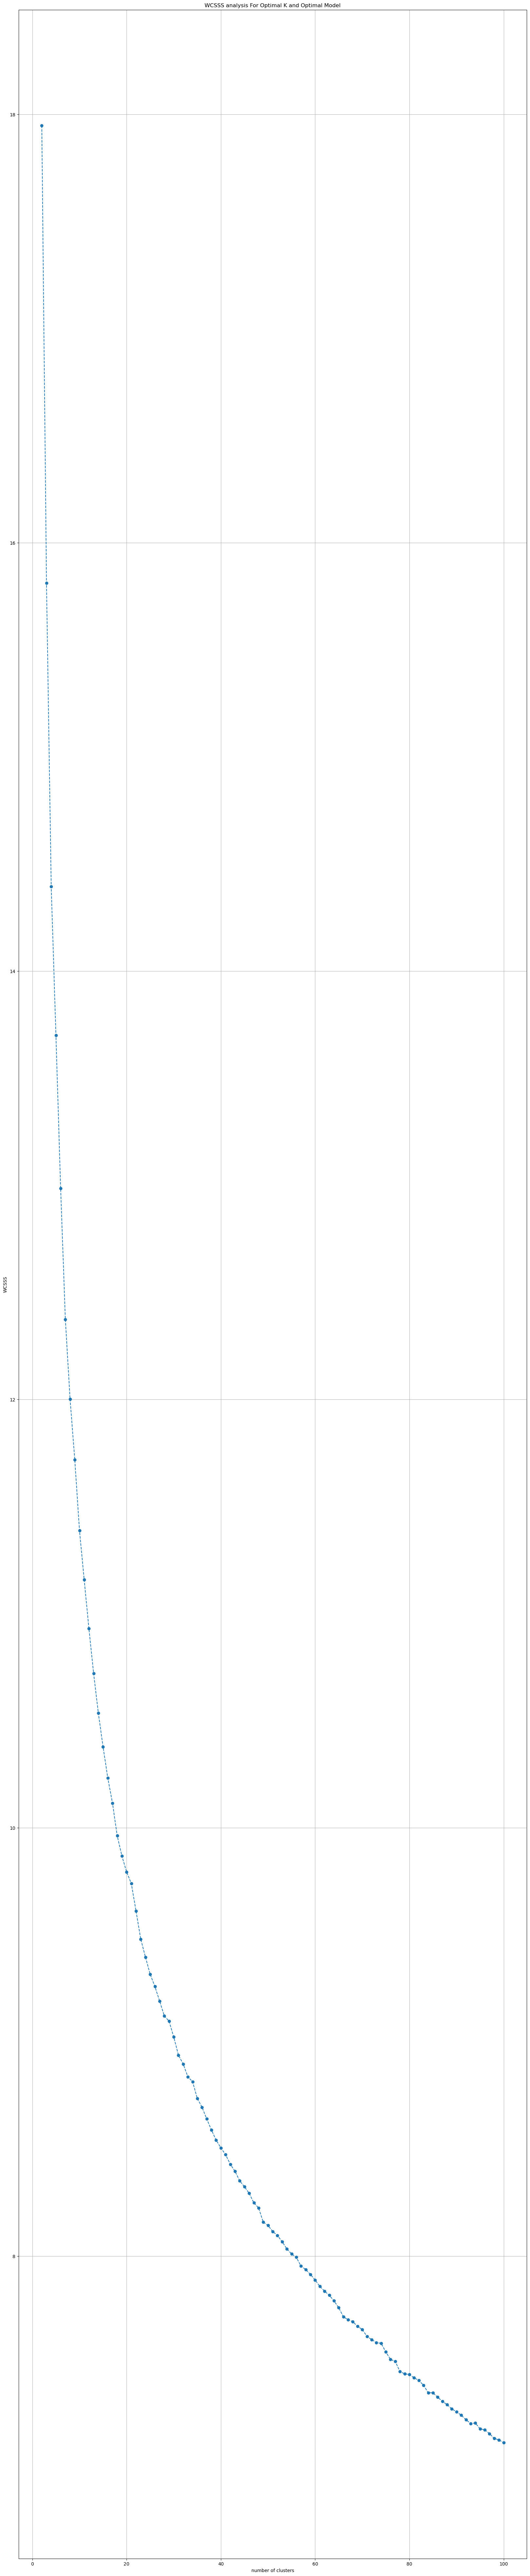

In [24]:
wcss=kmeans_wcsss(X_train,"euclidean","euclidean_t_25_k_100",100)

0         1         2         3         4         5   \
osvifr          0.451375  0.511643  0.498016  0.534963  0.547601  0.584373   
Anmelus         0.107348  0.032144  0.006019 -0.028003  0.244974  0.450300   
Tohotmos        0.392060  0.275824  0.269730  0.275133  0.303927  0.347773   
denij           0.071759  0.036074 -0.033340  0.023176  0.048462  0.075683   
diegoandrescas -0.169456 -0.148651 -0.092380 -0.047687 -0.006561 -0.034730   

                      6         7         8         9   ...        15  \
osvifr          0.551876  0.516761  0.538195  0.563498  ...  0.578022   
Anmelus         0.264592  0.422184  0.321665  0.153664  ...  0.187398   
Tohotmos        0.311817  0.284258  0.325602  0.354641  ...  0.376792   
denij           0.130788  0.158155  0.183873  0.204894  ...  0.096647   
diegoandrescas -0.042370 -0.058584 -0.032657 -0.007905  ... -0.096692   

                      16        17        18        19        20        21  \
osvifr          0.542295  0.565793  0.584798  0.561167  0.600219  0.549067   
Anmelus         0.281933  0.222699  0.190348  0.162611  0.130406  0.205646   
Tohotmos        0.400279  0.364669  0.328406  0.352024  0.363339  0.375383   
denij           0.112304  0.128053  0.182459  0.174449  0.213314  0.249067   
diegoandrescas -0.073105 -0.100677 -0.121268 -0.149131 -0.126215 -0.153565   

                      22        23        24  
osvifr          0.497777  0.449723  0.477749  
Anmelus         0.375449  0.508905  0.679053  
Tohotmos        0.343881  0.335306  0.284340  
denij           0.284690  0.319524  0.351441  
diegoandrescas -0.184892 -0.149983 -0.189316  

[5 rows x 25 columns]

In [27]:
# Experiment number 1. (1/2)
from sklearn.metrics import  calinski_harabasz_score
silhoutte_score_ss = []
X=df_ma.values
for i in range(2, 100):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X)
  print("1",time.time()-start)
  score_ss = calinski_harabasz_score(X, y_pred_ss)
  print("2",time.time()-start)

  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} {score_ss} seconds to calculate.")

1 2.7980077266693115
2 2.7997851371765137
K = 2. Took 2.80 10668.788850733585 seconds to calculate.
1 4.078265905380249
2 4.0800395011901855
K = 3. Took 4.08 11421.112946407708 seconds to calculate.
1 3.447502374649048
2 3.449392080307007
K = 4. Took 3.45 11767.315896384991 seconds to calculate.
1 4.076956510543823
2 4.079167366027832
K = 5. Took 4.08 12121.142638529402 seconds to calculate.
1 4.0197367668151855
2 4.021620273590088
K = 6. Took 4.02 13009.385633184767 seconds to calculate.
1 4.267179727554321
2 4.26910400390625
K = 7. Took 4.27 13060.467651225877 seconds to calculate.
1 4.240659952163696
2 4.242651700973511
K = 8. Took 4.24 13263.671306611912 seconds to calculate.
1 4.274981260299683
2 4.2774224281311035
K = 9. Took 4.28 13163.45827480958 seconds to calculate.
1 4.038917541503906
2 4.041033029556274
K = 10. Took 4.04 12745.090919143178 seconds to calculate.
1 4.172874212265015
2 4.175257205963135
K = 11. Took 4.18 12529.58548593571 seconds to calculate.
1 4.196189403533

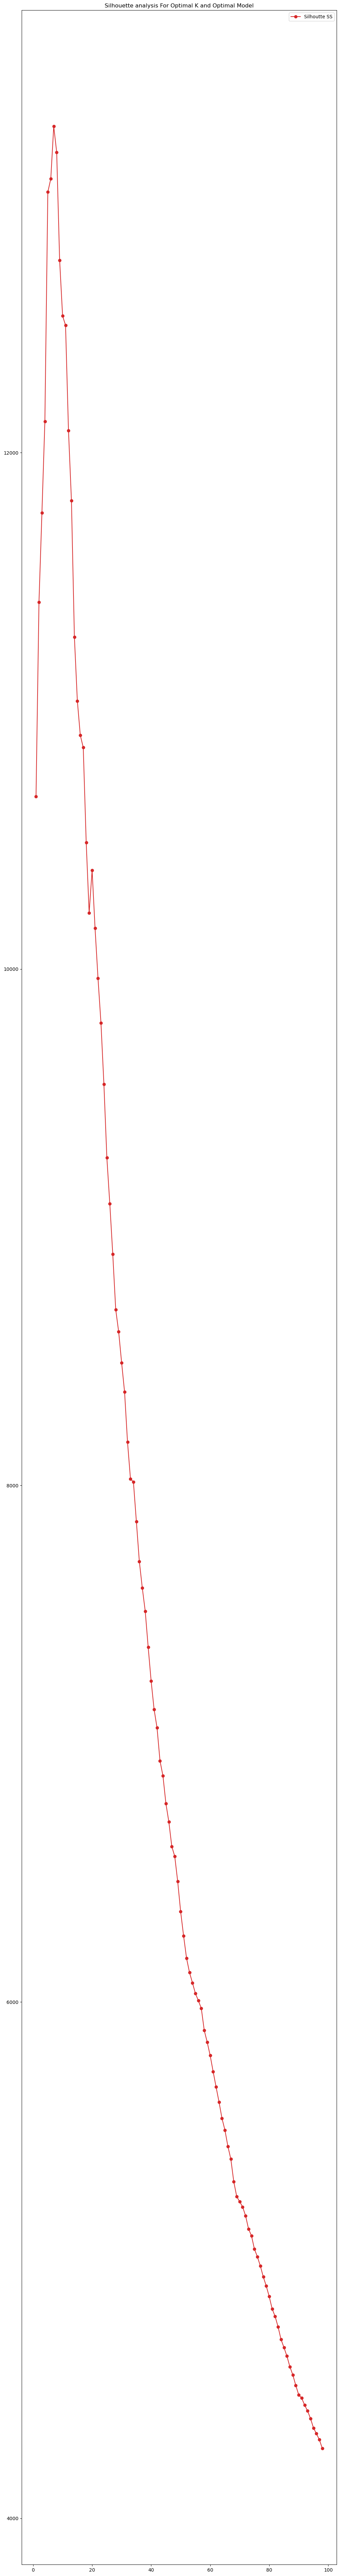

In [37]:
# Experiment number 1.
plt.figure(figsize=(12, 98))
plt.plot(range(1, 99), silhoutte_score_ss, "-o", c="C3")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS"]);
# plt.show()

In [39]:
max(silhoutte_score_ss)

13263.671306611912

In [40]:
best_i=0
for i in range(0,len(silhoutte_score_ss)):
    if max(silhoutte_score_ss)==silhoutte_score_ss[i]:
        best_i=i

best_i

6

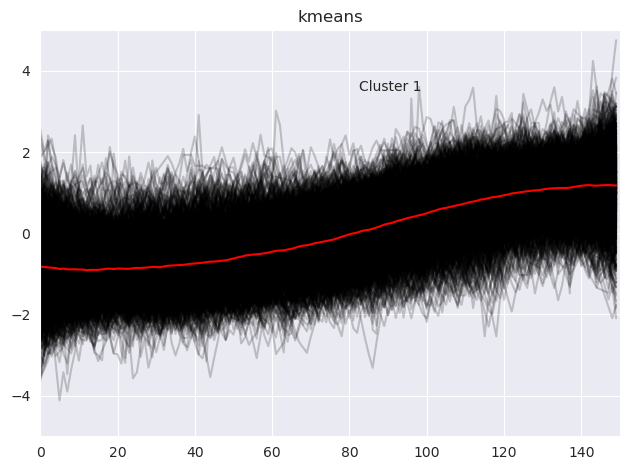

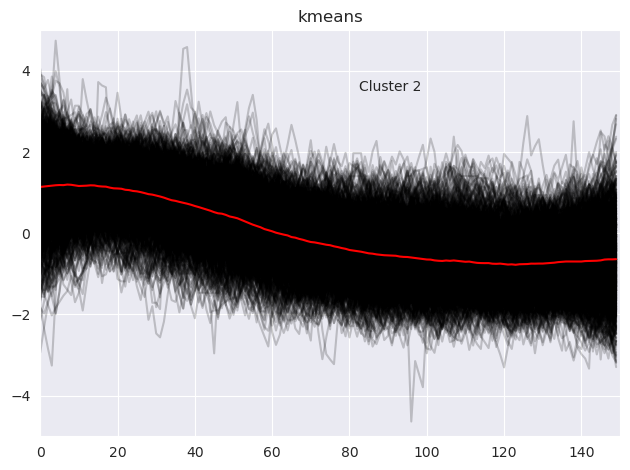

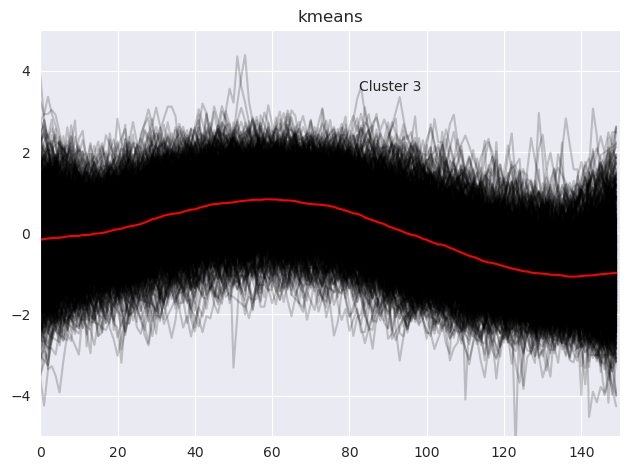

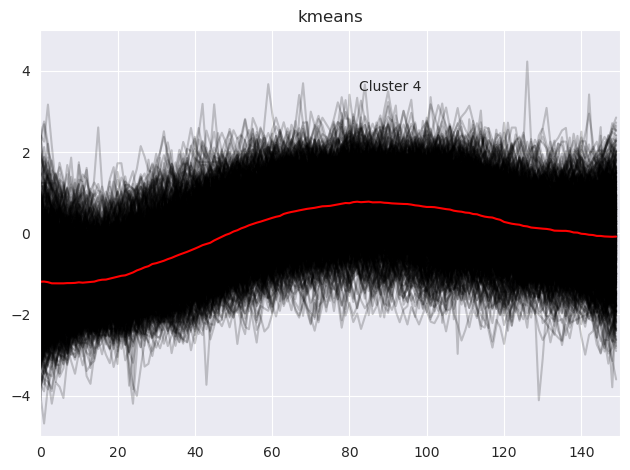

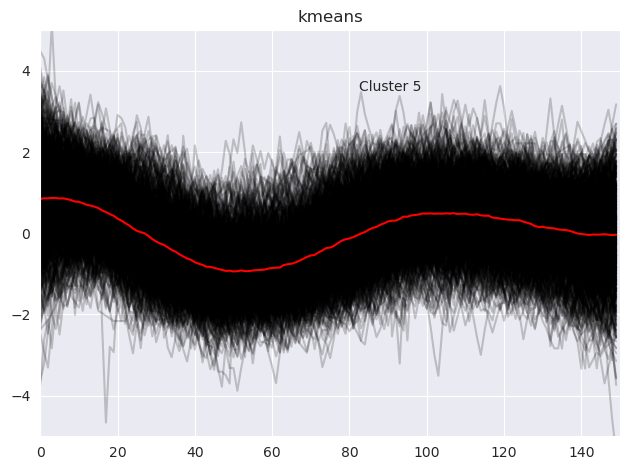

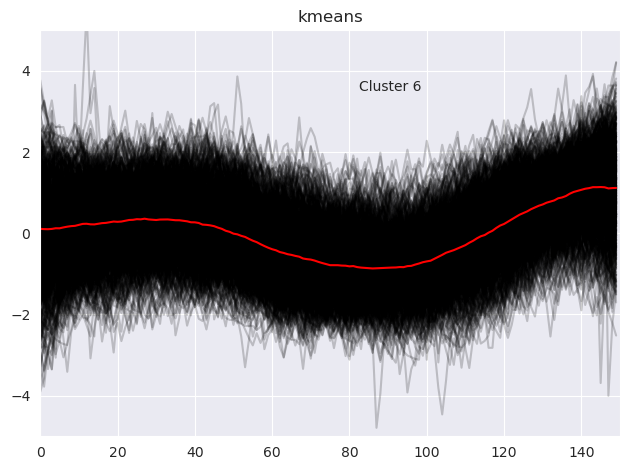

The 21.82% of the observations fall into Cluster 1
The 19.37% of the observations fall into Cluster 2
The 17.22% of the observations fall into Cluster 3
The 17.70% of the observations fall into Cluster 4
The 10.76% of the observations fall into Cluster 5
The 13.12% of the observations fall into Cluster 6


array([5, 5, 2, ..., 0, 5, 0])

In [178]:
kmeans_cluster(6, "euclidean",X_train,"euclidean")

In [28]:
wcss=kmeans_wcsss(X_train,"dtw","dtw_t_25_k_10",10)

KeyboardInterrupt: 

In [51]:
df=pd.DataFrame.from_dict(get_samples(players_dict,0,200)).T

In [53]:

%%time

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values
ss = StandardScaler()

scaled_ss = ss.fit_transform(df.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df.columns, index=df.index)
X_ss = df_ss.values
display(df_ss.head())

# Normalization
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df.columns, index=df.index)
X_mm = df_mm.values
display(df_mm.head())


# convert dataframe to time_series_dataset
X = to_time_series_dataset(df.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

0         1         2         3         4         5    \
osvifr          0.269382  0.497672  0.155237  0.421575  0.497672  0.764010   
Anmelus        -0.378265 -1.336318 -1.732753 -2.096152  0.150315  1.802129   
Tohotmos        1.802457  0.501646  0.268167  0.234813  0.434938  0.735125   
denij           0.037632 -0.615348 -1.405798 -0.993389 -0.821552 -0.649715   
diegoandrescas  1.798481  1.603164  1.954735  2.306306  2.657877  2.306306   

                     6         7         8         9    ...       190  \
osvifr          0.421575  0.041092  0.231334  0.459623  ...  2.095700   
Anmelus         0.216388  1.504803  0.645859 -0.774701  ...  0.877113   
Tohotmos        0.401584  0.134751  0.468292  0.701771  ... -0.565686   
denij          -0.202939  0.003265  0.209469  0.381306  ... -0.134205   
diegoandrescas  2.189115  1.993798  2.228179  2.462559  ... -1.014087   

                     191       192       193       194       195       196  \
osvifr          2.323990  2.476183  2.666425  2.323990  1.829362  1.677169   
Anmelus         0.612823  0.844077  0.645859  0.480678  0.315497  0.678896   
Tohotmos       -0.298853 -0.098728 -0.232145 -0.365561 -0.132082 -0.298853   
denij           0.312571 -0.134205  0.003265 -0.271674  0.140734 -0.099837   
diegoandrescas -1.092214 -1.170341 -1.326594 -1.600039 -1.756292 -1.990673   

                     197       198       199  
osvifr          1.905459  2.171797  2.362039  
Anmelus         0.612823  0.546751  0.348533  
Tohotmos        0.034688  0.201459  0.401584  
denij          -0.134205  0.312571  1.034287  
diegoandrescas -1.990673 -2.068800 -2.576625  

[5 rows x 200 columns]

0         1         2         3         4         5    \
osvifr          0.526316  0.571429  0.503759  0.556391  0.571429  0.624060   
Anmelus         0.325843  0.162921  0.095506  0.033708  0.415730  0.696629   
Tohotmos        0.946565  0.648855  0.595420  0.587786  0.633588  0.702290   
denij           0.462069  0.331034  0.172414  0.255172  0.289655  0.324138   
diegoandrescas  0.835821  0.798507  0.865672  0.932836  1.000000  0.932836   

                     6         7         8         9    ...       190  \
osvifr          0.556391  0.481203  0.518797  0.563910  ...  0.887218   
Anmelus         0.426966  0.646067  0.500000  0.258427  ...  0.539326   
Tohotmos        0.625954  0.564885  0.641221  0.694656  ...  0.404580   
denij           0.413793  0.455172  0.496552  0.531034  ...  0.427586   
diegoandrescas  0.910448  0.873134  0.917910  0.962687  ...  0.298507   

                     191       192       193       194       195       196  \
osvifr          0.932331  0.962406  1.000000  0.932331  0.834586  0.804511   
Anmelus         0.494382  0.533708  0.500000  0.471910  0.443820  0.505618   
Tohotmos        0.465649  0.511450  0.480916  0.450382  0.503817  0.465649   
denij           0.517241  0.427586  0.455172  0.400000  0.482759  0.434483   
diegoandrescas  0.283582  0.268657  0.238806  0.186567  0.156716  0.111940   

                     197       198       199  
osvifr          0.849624  0.902256  0.939850  
Anmelus         0.494382  0.483146  0.449438  
Tohotmos        0.541985  0.580153  0.625954  
denij           0.427586  0.517241  0.662069  
diegoandrescas  0.111940  0.097015  0.000000  

[5 rows x 200 columns]

(7275, 200, 1) (7275, 200, 1)
CPU times: user 660 ms, sys: 7.98 ms, total: 668 ms
Wall time: 667 ms


155.45669973324257
K = 2. Took 2.78 seconds to calculate.
141.02684260839862
K = 3. Took 1.96 seconds to calculate.
131.20437118564163
K = 4. Took 3.93 seconds to calculate.
125.46162758288102
K = 5. Took 8.89 seconds to calculate.
120.28293685949278
K = 6. Took 8.14 seconds to calculate.
116.94893882814382
K = 7. Took 9.39 seconds to calculate.
113.83512890912692
K = 8. Took 7.25 seconds to calculate.
111.15866361254112
K = 9. Took 6.54 seconds to calculate.
108.97842370830351
K = 10. Took 10.22 seconds to calculate.
107.30657536009339
K = 11. Took 9.84 seconds to calculate.
105.52564366460464
K = 12. Took 10.16 seconds to calculate.
104.00400944335773
K = 13. Took 9.79 seconds to calculate.
102.67302548502047
K = 14. Took 9.97 seconds to calculate.
101.77909900519239
K = 15. Took 10.14 seconds to calculate.
100.34693274744659
K = 16. Took 10.58 seconds to calculate.
99.26600840633883
K = 17. Took 9.70 seconds to calculate.
98.62097770215068
K = 18. Took 10.20 seconds to calculate.
97

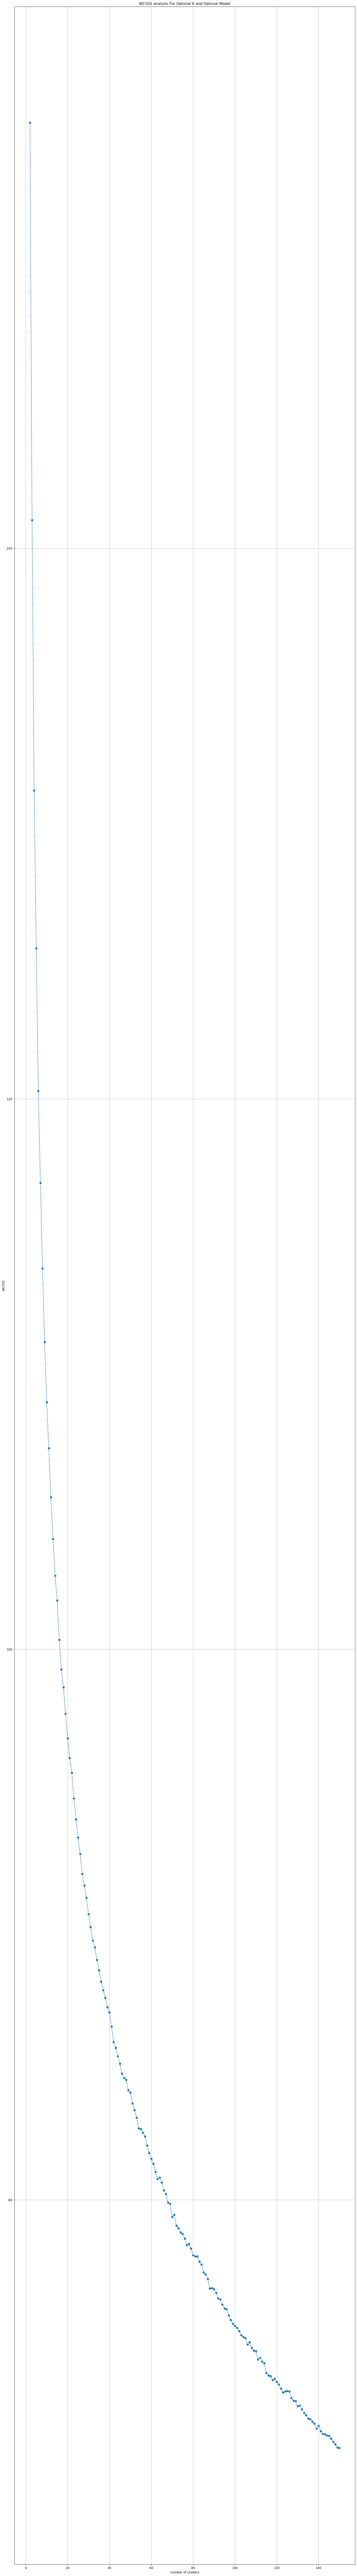

In [54]:
wcss=kmeans_wcsss(X_train,"euclidean","euclidean_t_150_k_100",150)

In [55]:
from sklearn.preprocessing import StandardScaler
df_ma=df
# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values 
# so the mean of observed values is 0 and the standard deviation is 1. 
# Taken from https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
ss = StandardScaler()
scaled_ss = ss.fit_transform(df_ma)
df_ss = pd.DataFrame(scaled_ss, columns=df_ma.columns, index=df_ma.index)
X_ss = df_ss.values
df_ss.head()

0         1         2         3         4         5    \
osvifr          0.453538  0.507423  0.492315  0.529231  0.541669  0.578533   
Anmelus         0.106585  0.023357 -0.003598 -0.038613  0.236001  0.443059   
Tohotmos        0.393718  0.269358  0.262212  0.267149  0.295546  0.339461   
denij           0.070694  0.027324 -0.043271  0.013009  0.037515  0.064528   
diegoandrescas -0.172572 -0.159160 -0.102781 -0.058467 -0.018062 -0.047039   

                     6         7         8         9    ...       190  \
osvifr          0.545463  0.509171  0.531037  0.557081  ...  0.700886   
Anmelus         0.255189  0.413595  0.312318  0.142956  ...  0.313048   
Tohotmos        0.302905  0.274212  0.316295  0.346037  ...  0.165109   
denij           0.119993  0.146777  0.173134  0.194722  ...  0.105134   
diegoandrescas -0.054966 -0.072252 -0.045585 -0.020304  ... -0.406653   

                     191       192       193       194       195       196  \
osvifr          0.724670  0.740526  0.759626  0.723286  0.670639  0.654476   
Anmelus         0.280870  0.308841  0.284222  0.263666  0.243310  0.287236   
Tohotmos        0.196908  0.220905  0.204322  0.187729  0.215354  0.195425   
denij           0.156926  0.104989  0.120427  0.087811  0.135479  0.107607   
diegoandrescas -0.414816 -0.422627 -0.438872 -0.467730 -0.483548 -0.507122   

                     197       198       199  
osvifr          0.678045  0.705937  0.725388  
Anmelus         0.279136  0.271039  0.246365  
Tohotmos        0.235256  0.255079  0.278300  
denij           0.103616  0.155332  0.238381  
diegoandrescas -0.506715 -0.514971 -0.567974  

[5 rows x 200 columns]

In [56]:
# Experiment number 1. (1/2)
from sklearn.metrics import  calinski_harabasz_score
silhoutte_score_ss = []
X=df_ma.values
for i in range(2, 100):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X)
  print("1",time.time()-start)
  score_ss = calinski_harabasz_score(X, y_pred_ss)
  print("2",time.time()-start)

  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} {score_ss} seconds to calculate.")

1 3.2613303661346436
2 3.268397808074951
K = 2. Took 3.27 10288.559325467773 seconds to calculate.
1 3.7779810428619385
2 3.783815860748291
K = 3. Took 3.78 11118.728380568778 seconds to calculate.
1 3.732274055480957
2 3.738731622695923
K = 4. Took 3.74 11504.774144679375 seconds to calculate.
1 3.885936737060547
2 3.8926358222961426
K = 5. Took 3.89 11819.134972223037 seconds to calculate.
1 4.06227445602417
2 4.06877064704895
K = 6. Took 4.07 13215.790907831357 seconds to calculate.
1 4.174685478210449
2 4.181436538696289
K = 7. Took 4.18 13374.908474838085 seconds to calculate.
1 4.106743574142456
2 4.113744258880615
K = 8. Took 4.11 13671.628683868132 seconds to calculate.
1 3.8518803119659424
2 3.858297109603882
K = 9. Took 3.86 13508.985709923725 seconds to calculate.
1 4.072508096694946
2 4.079341411590576
K = 10. Took 4.08 13280.323870075183 seconds to calculate.
1 4.111581087112427
2 4.118385553359985
K = 11. Took 4.12 13095.678441379718 seconds to calculate.
1 4.215403318405

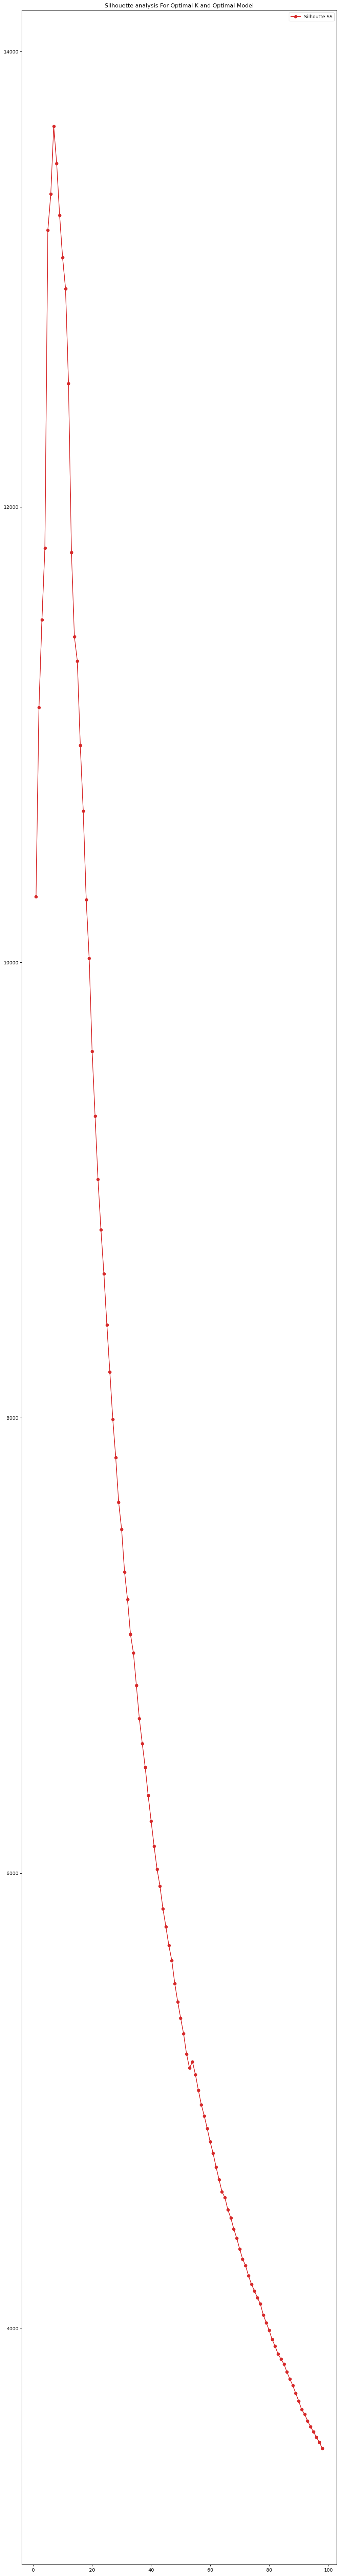

In [57]:
# Experiment number 1.
plt.figure(figsize=(12, 98))
plt.plot(range(1, 99), silhoutte_score_ss, "-o", c="C3")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS"]);
# plt.show()

In [58]:
best_i=0
for i in range(0,len(silhoutte_score_ss)):
    if max(silhoutte_score_ss)==silhoutte_score_ss[i]:
        best_i=i

best_i

6

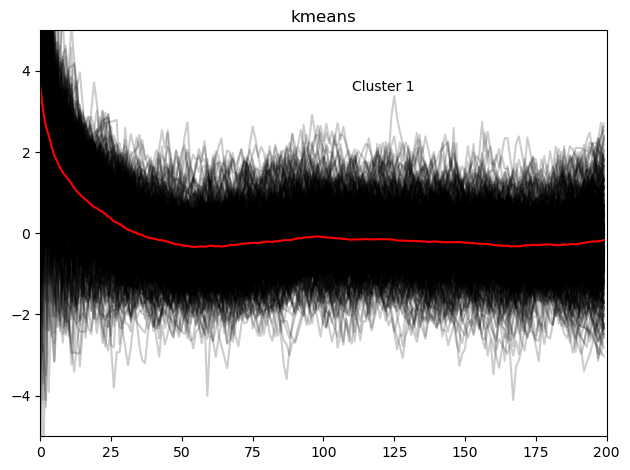

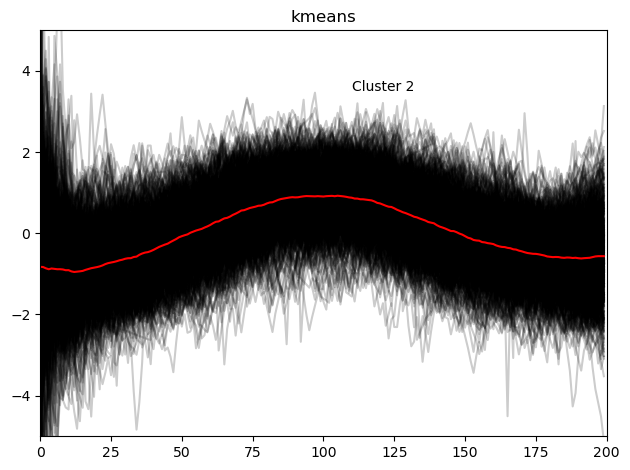

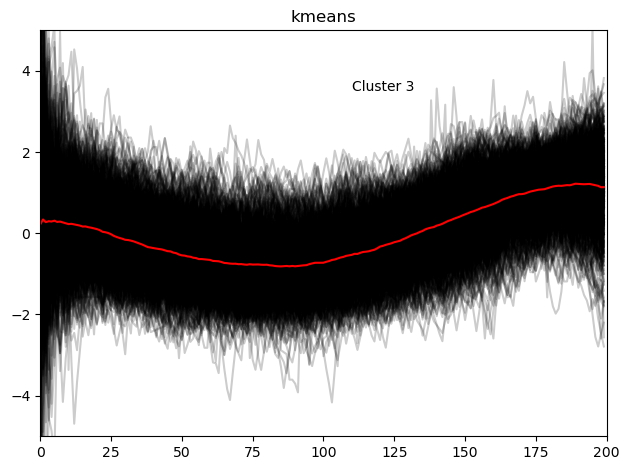

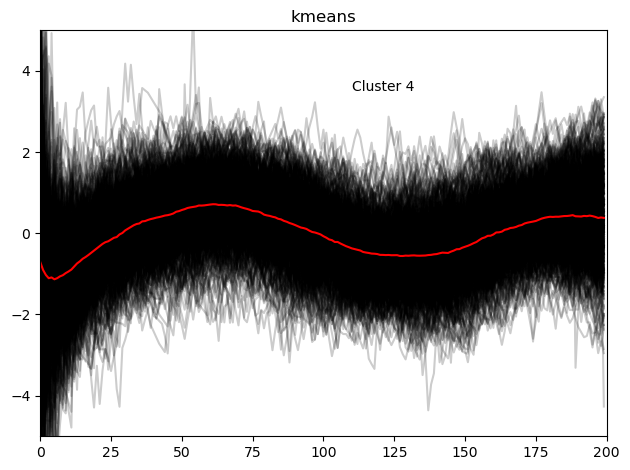

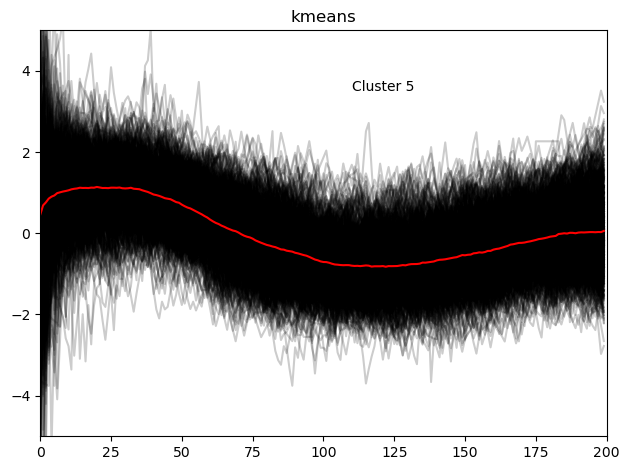

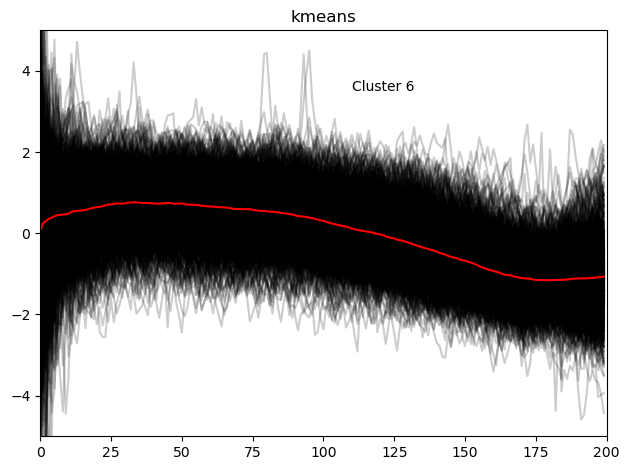

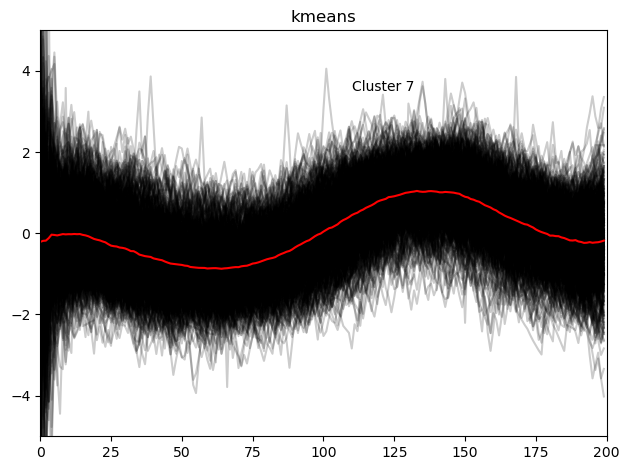

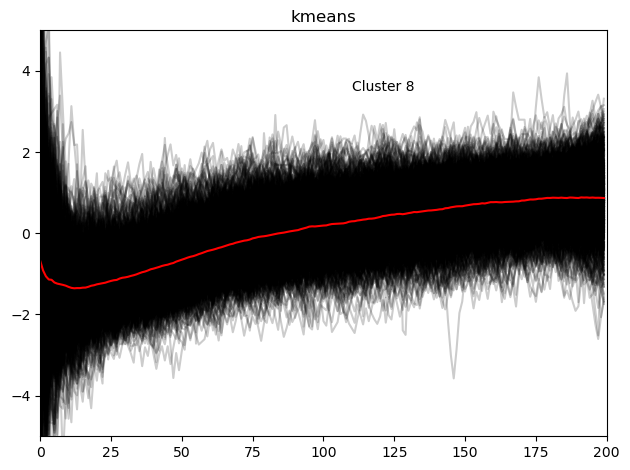

The 9.57% of the observations fall into Cluster 1
The 11.73% of the observations fall into Cluster 2
The 13.72% of the observations fall into Cluster 3
The 8.89% of the observations fall into Cluster 4
The 12.29% of the observations fall into Cluster 5
The 15.52% of the observations fall into Cluster 6
The 9.50% of the observations fall into Cluster 7
The 18.79% of the observations fall into Cluster 8


array([3, 3, 1, ..., 2, 3, 2])

In [60]:
kmeans_cluster(8, "euclidean",X_train,"euclidean")

In [67]:
var_list=[]
for i in range(len(df.columns)):
    arr=list(df[i])
    var_list.append(np.var(arr))

In [72]:
best_i=0
for i in range(0,50):
    if min(var_list[:50])==var_list[i]:
        best_i=i

best_i
plt.plot(var_list)

42

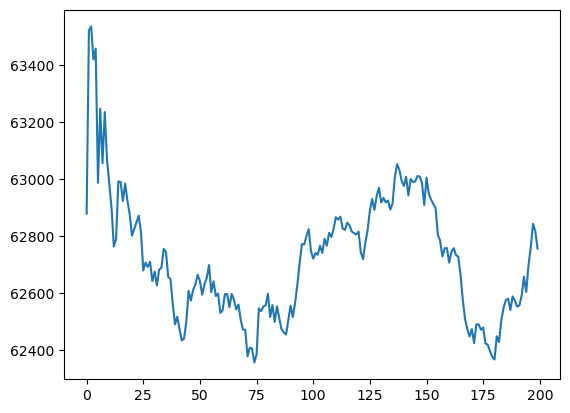

In [179]:
df=pd.DataFrame.from_dict(get_samples(players_dict,42,150)).T

In [180]:
for i in df.index:
    if "bot" in i:
        df=df[df.index!=i]

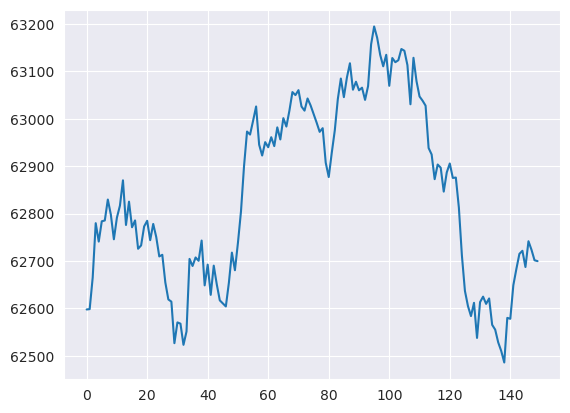

In [170]:
var_list=[]
for i in range(len(df.columns)):
    arr=list(df[i])
    var_list.append(np.var(arr))
best_i=0
for i in range(0,50):
    if min(var_list[:50])==var_list[i]:
        best_i=i

best_i
plt.plot(var_list)

In [181]:

%%time

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values
ss = StandardScaler()

scaled_ss = ss.fit_transform(df.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df.columns, index=df.index)
X_ss = df_ss.values
display(df_ss.head())

# Normalization
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df.columns, index=df.index)
X_mm = df_mm.values
display(df_mm.head())


# convert dataframe to time_series_dataset
X = to_time_series_dataset(df.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

0         1         2         3         4         5    \
osvifr         -0.584372 -0.313471 -0.623072 -0.468272 -0.932673 -0.661772   
Anmelus        -2.141894 -2.250498 -2.359101 -2.467704 -1.562678 -0.693853   
Tohotmos       -0.829283 -1.012438 -0.707180 -1.012438 -1.378747 -1.684005   
denij           0.967819  1.133429  1.299038  1.464647  1.232794  1.564012   
diegoandrescas  0.738878  0.471942  0.311781 -0.061929 -0.328865 -0.649187   

                     6         7         8         9    ...       140  \
osvifr         -0.390871 -0.429572 -0.274771 -0.003870  ...  2.008537   
Anmelus        -0.983461 -0.295642  0.319776 -0.006034  ...  0.428379   
Tohotmos       -1.470325 -1.287170 -1.378747 -0.951387  ... -0.859809   
denij           1.166550  1.299038  1.166550  1.100307  ...  1.994596   
diegoandrescas -0.702575 -0.222090 -0.542413 -0.809349  ... -0.115316   

                     141       142       143       144       145       146  \
osvifr          2.124638  2.240738  2.550339  2.163338  2.395539  2.047238   
Anmelus         0.174972  0.392178  0.681786  0.971394  1.261003  0.935193   
Tohotmos       -0.798758 -0.585077 -0.707180 -0.340871 -0.524026 -0.432448   
denij           1.232794  0.570358  0.934698  1.000941  1.232794  0.504114   
diegoandrescas -0.542413 -0.916123 -0.969510 -0.275478 -0.595800 -0.862736   

                     147       148       149  
osvifr          2.124638  2.240738  2.472939  
Anmelus         1.297204  1.007595  0.717987  
Tohotmos       -0.646129 -0.462974 -0.218768  
denij          -0.588906 -0.025835  0.404749  
diegoandrescas -0.595800 -1.076284 -1.183059  

[5 rows x 150 columns]

0         1         2         3         4         5    \
osvifr          0.357143  0.412698  0.349206  0.380952  0.285714  0.341270   
Anmelus         0.067669  0.045113  0.022556  0.000000  0.187970  0.368421   
Tohotmos        0.312977  0.267176  0.343511  0.267176  0.175573  0.099237   
denij           0.634483  0.668966  0.703448  0.737931  0.689655  0.758621   
diegoandrescas  0.553191  0.500000  0.468085  0.393617  0.340426  0.276596   

                     6         7         8         9    ...       140  \
osvifr          0.396825  0.388889  0.420635  0.476190  ...  0.888889   
Anmelus         0.308271  0.451128  0.578947  0.511278  ...  0.601504   
Tohotmos        0.152672  0.198473  0.175573  0.282443  ...  0.305344   
denij           0.675862  0.703448  0.675862  0.662069  ...  0.848276   
diegoandrescas  0.265957  0.361702  0.297872  0.244681  ...  0.382979   

                     141       142       143       144       145       146  \
osvifr          0.912698  0.936508  1.000000  0.920635  0.968254  0.896825   
Anmelus         0.548872  0.593985  0.654135  0.714286  0.774436  0.706767   
Tohotmos        0.320611  0.374046  0.343511  0.435115  0.389313  0.412214   
denij           0.689655  0.551724  0.627586  0.641379  0.689655  0.537931   
diegoandrescas  0.297872  0.223404  0.212766  0.351064  0.287234  0.234043   

                     147       148       149  
osvifr          0.912698  0.936508  0.984127  
Anmelus         0.781955  0.721805  0.661654  
Tohotmos        0.358779  0.404580  0.465649  
denij           0.310345  0.427586  0.517241  
diegoandrescas  0.287234  0.191489  0.170213  

[5 rows x 150 columns]

(7322, 150, 1) (7322, 150, 1)
CPU times: user 734 ms, sys: 0 ns, total: 734 ms
Wall time: 734 ms


In [182]:
wcss=kmeans_wcsss(df_ss,"euclidean","euclidean_t_150x_k_100",100)

109.6606259708285
K = 2. Took 2.47 seconds to calculate.
98.2209064806518
K = 3. Took 3.24 seconds to calculate.
89.92544732614886
K = 4. Took 9.34 seconds to calculate.
85.39929372390051
K = 5. Took 4.61 seconds to calculate.
81.74851828374601
K = 6. Took 9.43 seconds to calculate.
78.86318194335506
K = 7. Took 9.65 seconds to calculate.
76.81259798808831
K = 8. Took 10.03 seconds to calculate.
75.26215578133798
K = 9. Took 8.54 seconds to calculate.
73.7277590638095
K = 10. Took 6.55 seconds to calculate.


KeyboardInterrupt: 

In [184]:
# Experiment number 1. (1/2)
from sklearn.metrics import  calinski_harabasz_score
silhoutte_score_ss = []
X=df.values
for i in range(2, 100):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X)
  print("1",time.time()-start)
  score_ss = calinski_harabasz_score(X, y_pred_ss)
  print("2",time.time()-start)

  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} {score_ss} seconds to calculate.")

1 3.4000797271728516
2 3.4046456813812256
K = 2. Took 3.40 10643.045694285693 seconds to calculate.
1 4.1671671867370605
2 4.172064781188965
K = 3. Took 4.17 11710.269280558594 seconds to calculate.
1 4.133761167526245
2 4.138895273208618
K = 4. Took 4.14 12272.982359115234 seconds to calculate.
1 4.16546630859375
2 4.171006441116333
K = 5. Took 4.17 13223.656102309069 seconds to calculate.
1 4.066995859146118
2 4.071924686431885
K = 6. Took 4.07 15018.153272652908 seconds to calculate.


KeyboardInterrupt: 

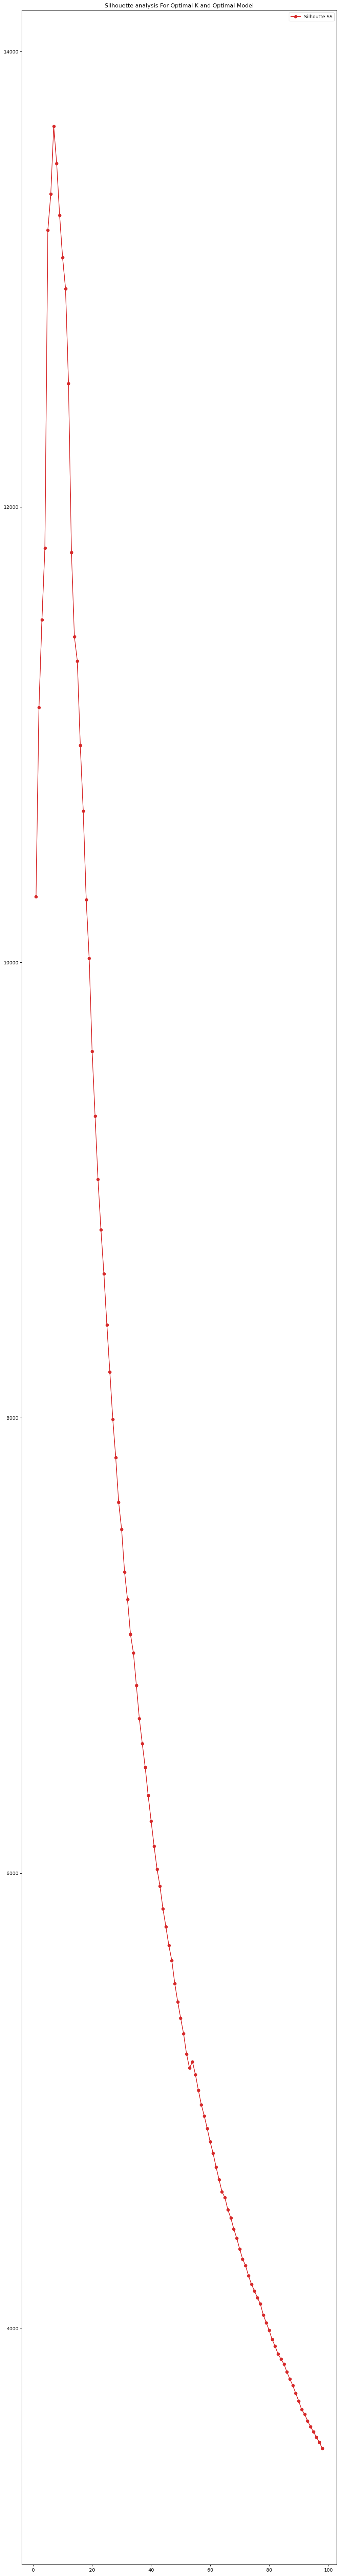

In [124]:
# Experiment number 1.
plt.figure(figsize=(12, 98))
plt.plot(range(1, 99), silhoutte_score_ss, "-o", c="C3")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS"]);
# plt.show()

In [125]:
best_i=0
for i in range(0,len(silhoutte_score_ss)):
    if max(silhoutte_score_ss)==silhoutte_score_ss[i]:
        best_i=i

best_i

6

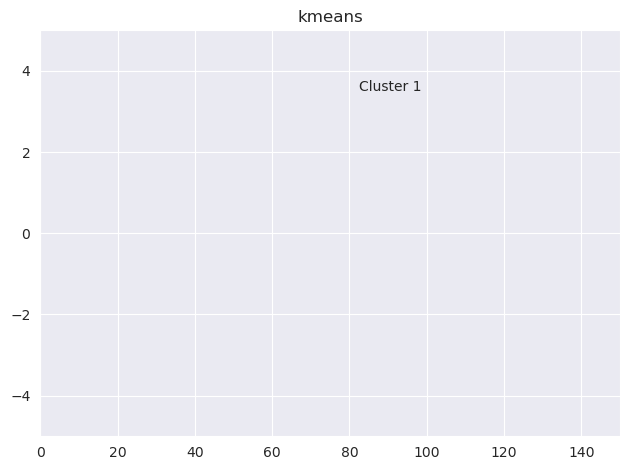

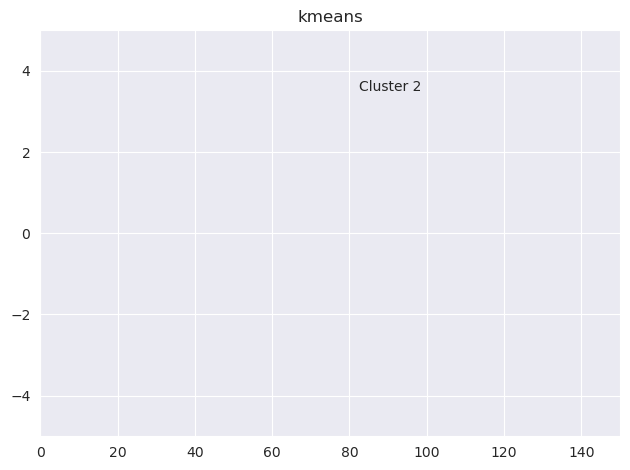

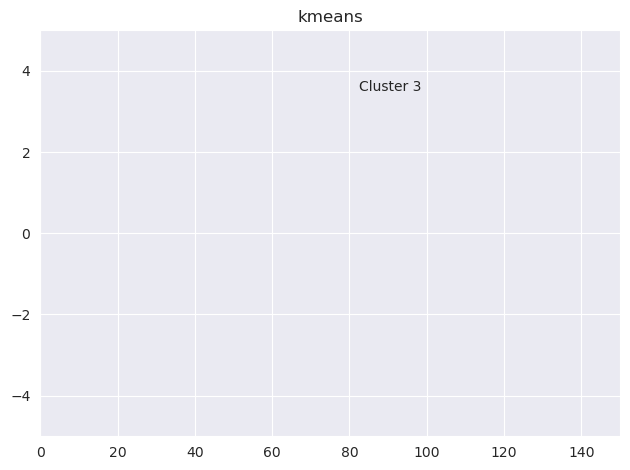

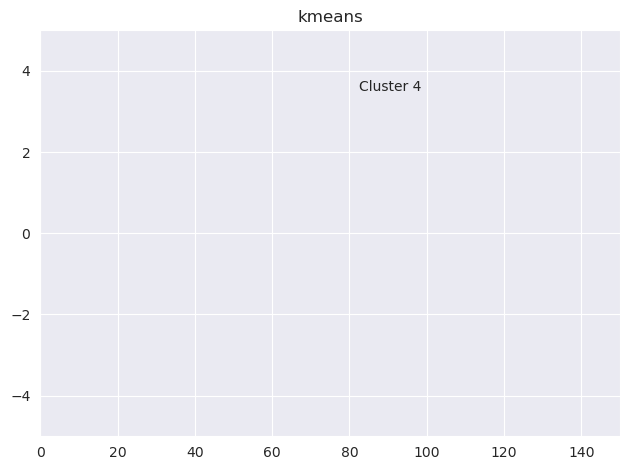

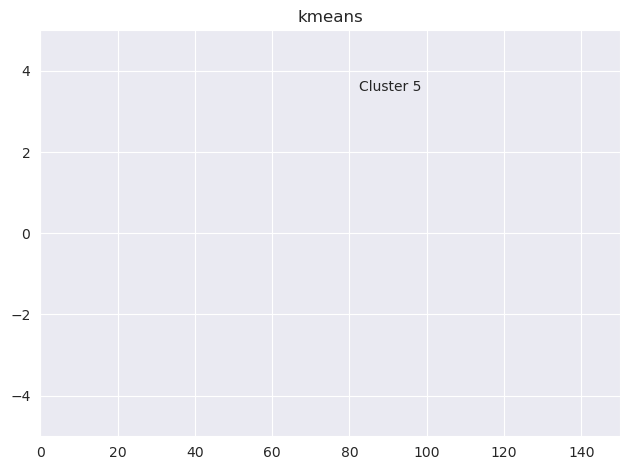

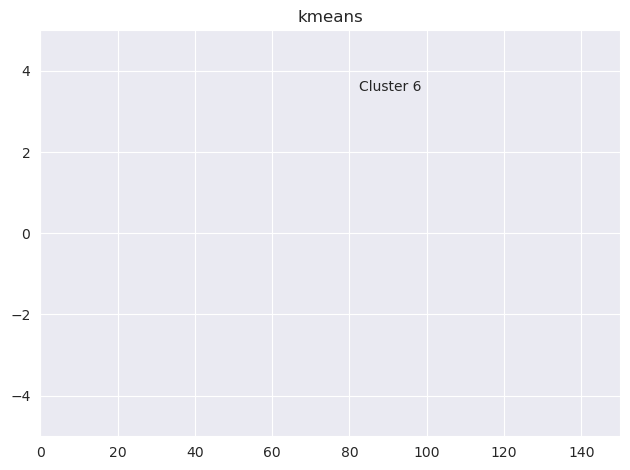

The 29.23% of the observations fall into Cluster 1
The 12.63% of the observations fall into Cluster 2
The 21.57% of the observations fall into Cluster 3
The 0.49% of the observations fall into Cluster 4
The 9.70% of the observations fall into Cluster 5
The 26.39% of the observations fall into Cluster 6


In [186]:
labels=kmeans_cluster(6, "euclidean",X,"euclidean")

In [216]:
df["Label"]=labels

In [218]:
df_old=df.copy()

In [219]:
df=df[df["Label"]==5]

In [192]:
groups=zip(labels,X)
my_d={}

for l,s in groups:
    my_d[l]=my_d.get(l,[])
    my_d[l].append(s)
len(labels),len(X)
# plt.plot(X[0])
# plt.plot(X[1])

(7322, 7322)

IndexError: list index out of range

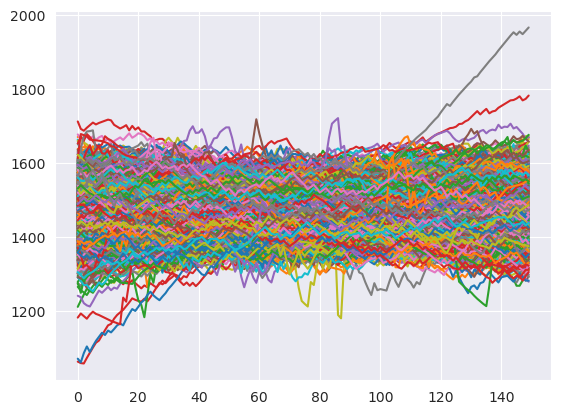

In [209]:
for i in range(10000):
    plt.plot(my_d[0][i])


IndexError: list index out of range

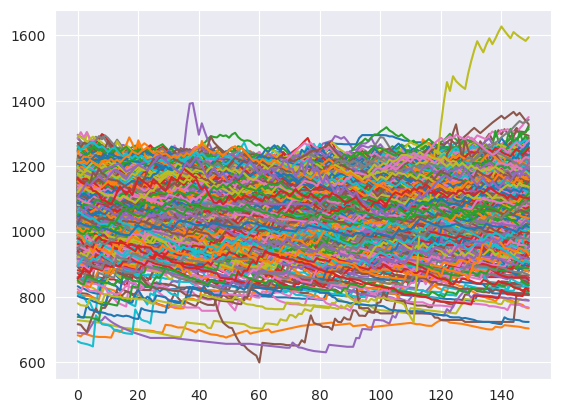

In [210]:
for i in range(1000):
    plt.plot(my_d[1][i])


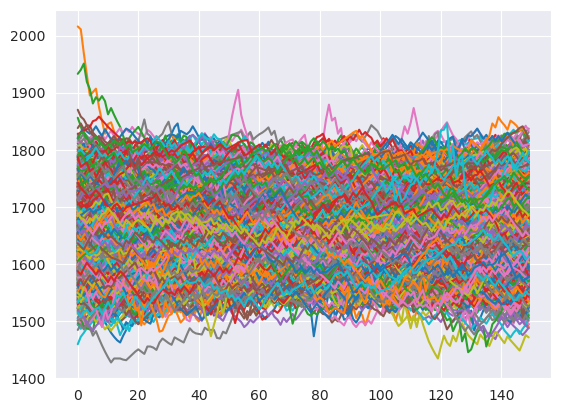

In [211]:
for i in range(1000):
    plt.plot(my_d[2][i])


IndexError: list index out of range

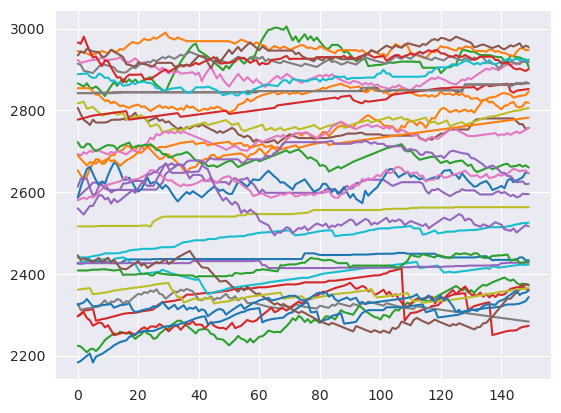

In [212]:
for i in range(800):
    plt.plot(my_d[3][i])


IndexError: list index out of range

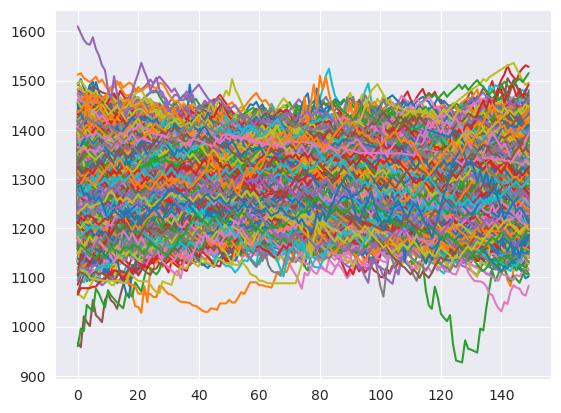

In [213]:
for i in range(10000):
    plt.plot(my_d[5][i])


IndexError: list index out of range

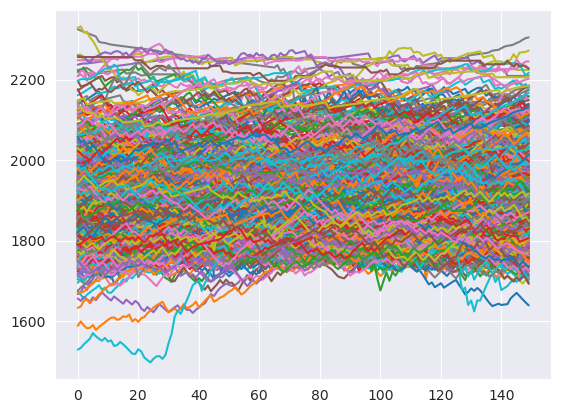

In [214]:
for i in range(10000):
    plt.plot(my_d[4][i])


In [232]:
df=df_old

In [236]:
df_dt=df.copy()

In [240]:
df_dt.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           141,     142,     143,     144,     145,     146,     147,     148,
           149, 'Label'],
      dtype='object', length=151)

In [245]:
for i in range(1,len(df_dt.columns)-1):
    df_dt[i]=df[i]-df[i-1]

df_dt[0]=df[0]-df[0]

In [269]:
improving=[]
not_improving=[]
getting_worse=[]
for p in df.index:
    if sum((list(df_dt[df_dt.index==p].values))[0])>0:
        improving.append(p)
    elif sum((list(df_dt[df_dt.index==p].values))[0])==0:
        not_improving.append(p)
    else:
        getting_worse.append(p)




In [270]:
len(getting_worse),len(improving),len(not_improving)

(3254, 4019, 49)

In [272]:
for i in range(len(getting_worse)):
    plt.plot(df[df.index==getting_worse[i]].values)


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7c81825bc7c0>
Traceback (most recent call last):
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


KeyboardInterrupt: 

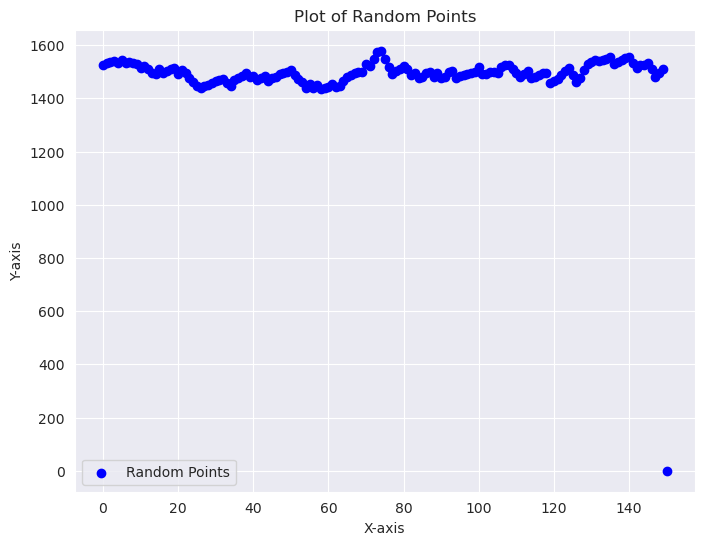

In [271]:
# Creating the plot
plt.figure(figsize=(8, 6))
plt.scatter(x=[i for i in range(0,151)],y=df[df.index==getting_worse[0]].values, color='blue', label='Random Points')
plt.title('Plot of Random Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

In [199]:
wcss=kmeans_wcsss(X,"dtw","dtw_t_150_k_100",15)

KeyboardInterrupt: 

In [226]:

%%time

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values
ss = StandardScaler()

scaled_ss = ss.fit_transform(df.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df.columns, index=df.index)
X_ss = df_ss.values
display(df_ss.head())

# Normalization
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df.columns, index=df.index)
X_mm = df_mm.values
display(df_mm.head())


# convert dataframe to time_series_dataset
X = to_time_series_dataset(df.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

0         1         2         3         4         5    \
krasic      1.474065  1.528047  1.716983  1.474065  1.231146  1.042210   
inemuri    -0.257850 -0.027969 -0.027969  0.115707  0.259383  0.403059   
yanjasa     1.892017  2.206349  1.970600  1.813434  1.970600  1.813434   
lotfour    -1.680702 -1.539403 -1.850261 -1.708962 -1.595923 -1.482884   
ronyshikha -1.471842 -1.512852 -1.533357 -1.553862 -1.553862 -1.656386   

                 6         7         8         9    ...       140       141  \
krasic      0.799292  1.015219  0.772301  0.610355  ... -1.737856 -1.467947   
inemuri     0.489264  0.575470  0.661675  0.747881  ... -1.206111 -1.263581   
yanjasa     1.656268  2.127766  1.852725  1.656268  ... -0.858388 -0.386890   
lotfour    -1.595923 -1.765481 -1.680702 -1.595923  ...  0.890936  0.551819   
ronyshikha -1.758911 -1.758911 -1.758911 -1.758911  ...  0.804202  0.763192   

                 142       143       144       145       146       147  \
krasic     -1.548920 -1.602902 -1.332992 -1.521929 -1.386974 -1.063083   
inemuri    -1.550933 -1.579668 -1.809549 -1.694609 -1.550933 -1.407257   
yanjasa    -0.033267 -0.308307 -0.583348 -0.190433  0.281065  0.123899   
lotfour     0.410520  0.551819  0.269221  0.043143  0.269221  0.269221   
ronyshikha  0.763192  0.763192  0.763192  0.722183  0.681173  0.640163   

                 148       149  
krasic     -0.901137 -1.090074  
inemuri    -1.263581 -0.890024  
yanjasa    -0.033267  0.359648  
lotfour     0.014883  0.043143  
ronyshikha  0.599153  0.927232  

[5 rows x 150 columns]

0         1         2         3         4         5    \
krasic      0.929688  0.945312  1.000000  0.929688  0.859375  0.804688   
inemuri     0.400000  0.455172  0.455172  0.489655  0.524138  0.558621   
yanjasa     0.925926  1.000000  0.944444  0.907407  0.944444  0.907407   
lotfour     0.134921  0.174603  0.087302  0.126984  0.158730  0.190476   
ronyshikha  0.349462  0.338710  0.333333  0.327957  0.327957  0.301075   

                 6         7         8         9    ...       140       141  \
krasic      0.734375  0.796875  0.726562  0.679688  ...  0.000000  0.078125   
inemuri     0.579310  0.600000  0.620690  0.641379  ...  0.172414  0.158621   
yanjasa     0.870370  0.981481  0.916667  0.870370  ...  0.277778  0.388889   
lotfour     0.158730  0.111111  0.134921  0.158730  ...  0.857143  0.761905   
ronyshikha  0.274194  0.274194  0.274194  0.274194  ...  0.946237  0.935484   

                 142       143       144       145       146       147  \
krasic      0.054688  0.039062  0.117188  0.062500  0.101562  0.195312   
inemuri     0.089655  0.082759  0.027586  0.055172  0.089655  0.124138   
yanjasa     0.472222  0.407407  0.342593  0.435185  0.546296  0.509259   
lotfour     0.722222  0.761905  0.682540  0.619048  0.682540  0.682540   
ronyshikha  0.935484  0.935484  0.935484  0.924731  0.913978  0.903226   

                 148       149  
krasic      0.242188  0.187500  
inemuri     0.158621  0.248276  
yanjasa     0.472222  0.564815  
lotfour     0.611111  0.619048  
ronyshikha  0.892473  0.978495  

[5 rows x 150 columns]

(1932, 150, 1) (1932, 150, 1)
CPU times: user 202 ms, sys: 0 ns, total: 202 ms
Wall time: 201 ms


In [ ]:
!pip install tsfresh

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram
from tqdm.autonotebook import tqdm

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

SEED=23

In [138]:
dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED)

In [156]:
df=df.T

In [157]:
for p in df.columns:
    df[p]=df[p].rolling(window=10).mean()

In [224]:
df=df.drop(columns=["Label"])

In [164]:
df=df[df.index>8]
df=df.T

In [228]:
df_ss

0         1         2         3         4         5    \
krasic      1.474065  1.528047  1.716983  1.474065  1.231146  1.042210   
inemuri    -0.257850 -0.027969 -0.027969  0.115707  0.259383  0.403059   
yanjasa     1.892017  2.206349  1.970600  1.813434  1.970600  1.813434   
lotfour    -1.680702 -1.539403 -1.850261 -1.708962 -1.595923 -1.482884   
ronyshikha -1.471842 -1.512852 -1.533357 -1.553862 -1.553862 -1.656386   
...              ...       ...       ...       ...       ...       ...   
Rolwade     0.593652  0.413549  0.259176  0.104802 -0.049571 -0.229673   
bretteux    0.322404  0.534719  0.605490  0.817805  0.629081  0.699853   
WildAngel  -0.422748 -0.753019 -0.381464 -0.670451 -0.340180 -0.133760   
replo       1.019497  1.108892  0.542725  0.632120  0.304339  0.393734   
swhite     -0.739770 -0.985220 -0.940592 -1.163728 -1.186042 -1.364551   

                 6         7         8         9    ...       140       141  \
krasic      0.799292  1.015219  0.772301  0.610355  ... -1.737856 -1.467947   
inemuri     0.489264  0.575470  0.661675  0.747881  ... -1.206111 -1.263581   
yanjasa     1.656268  2.127766  1.852725  1.656268  ... -0.858388 -0.386890   
lotfour    -1.595923 -1.765481 -1.680702 -1.595923  ...  0.890936  0.551819   
ronyshikha -1.758911 -1.758911 -1.758911 -1.758911  ...  0.804202  0.763192   
...              ...       ...       ...       ...  ...       ...       ...   
Rolwade    -0.384047 -0.126758 -0.332589 -0.101029  ... -2.262257 -2.493817   
bretteux    0.770624  0.841396  0.888577  0.935758  ... -0.220178 -0.007864   
WildAngel   0.072660 -0.340180 -0.092476  0.196512  ... -1.289710 -1.000723   
replo       0.155348  0.423532  0.065953 -0.470415  ... -0.291626 -0.947187   
swhite     -1.297610 -1.096787 -0.918279 -0.739770  ...  1.201513  1.313081   

                 142       143       144       145       146       147  \
krasic     -1.548920 -1.602902 -1.332992 -1.521929 -1.386974 -1.063083   
inemuri    -1.550933 -1.579668 -1.809549 -1.694609 -1.550933 -1.407257   
yanjasa    -0.033267 -0.308307 -0.583348 -0.190433  0.281065  0.123899   
lotfour     0.410520  0.551819  0.269221  0.043143  0.269221  0.269221   
ronyshikha  0.763192  0.763192  0.763192  0.722183  0.681173  0.640163   
...              ...       ...       ...       ...       ...       ...   
Rolwade    -2.699648 -2.905479 -3.085581 -2.854021 -2.622461 -2.339443   
bretteux    0.062908 -0.149407 -0.338131 -0.456084 -0.644808 -0.432493   
WildAngel  -0.753019 -0.546599 -0.340180 -0.133760 -0.546599 -0.587883   
replo      -0.559810 -0.232029  0.065953 -0.470415 -0.232029 -0.410819   
swhite      0.978377  1.201513  0.732927  0.933749  1.223826  1.179199   

                 148       149  
krasic     -0.901137 -1.090074  
inemuri    -1.263581 -0.890024  
yanjasa    -0.033267  0.359648  
lotfour     0.014883  0.043143  
ronyshikha  0.599153  0.927232  
...              ...       ...  
Rolwade    -2.107883 -1.902052  
bretteux   -0.243769 -0.432493  
WildAngel  -0.257612  0.113944  
replo      -0.798196 -1.185573  
swhite      1.402335  1.580844  

[1932 rows x 150 columns]

In [230]:
# Experiment number 1. (1/2)
from sklearn.metrics import  calinski_harabasz_score
silhoutte_score_ss = []
X=df_ss.values
wcss=[]
for i in range(2, 15):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X)
  print("1",time.time()-start)
  score_ss = calinski_harabasz_score(X, y_pred_ss)
  print("2",time.time()-start)

  silhoutte_score_ss.append(score_ss)
  wcss.append(km.inertia_)


  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took |{duration:.2f}| {score_ss} |{km.inertia_} |seconds to calculate.")

1 104.44124722480774
2 104.44282054901123
K = 2. Took |104.44| 543.0063416375225 |20.622320579820315 |seconds to calculate.
1 122.10403227806091
2 122.10567355155945
K = 3. Took |122.11| 352.0844221922772 |18.28787485406242 |seconds to calculate.
1 189.96262192726135
2 189.96391916275024
K = 4. Took |189.96| 281.4370978163671 |16.263110340355887 |seconds to calculate.


KeyboardInterrupt: 

In [ ]:
# Experiment number 1.
plt.figure(figsize=(12, 15))
plt.plot(range(1, 15), silhoutte_score_ss, "-o", c="C3")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS"]);
# plt.show()

In [ ]:
# Experiment number 1.
plt.figure(figsize=(12, 15))
plt.plot(range(1, 15), wcss, "-o", c="C3")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS"]);
# plt.show()

In [ ]:
best_i=0
for i in range(0,len(silhoutte_score_ss)):
    if max(silhoutte_score_ss)==silhoutte_score_ss[i]:
        best_i=i

best_i

In [ ]:
kmeans_cluster(best_i, "dxxxtw",X,"dtw")